# Análise das medidas do cálculo coerência do conjunto de dados CohQuAD In en .

Realiza a análise dos cálculos de medida de coerência utilizando BERT.

Utiliza os arquivos resultantes da medição de `X` documentos perturbados e `Y` top K predições.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [12]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [16]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [17]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Parametrização

## Gerais

In [18]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCohQuADInen_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [19]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_IN_EN"

## Define o caminho para os arquivos de dados

In [20]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [21]:
CONJUNTO_DADOS = 'CohQuAD In en'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [22]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  # MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  MODELO_BERT = ['_BERT', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [23]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [24]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERT 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1 
  Equação               : _com 
  Estratégia            : _mean 
  Filtro                : _svs 
  Resultado             : 0.75 
  Medida                : cman 
  Tempo execução        : 0:00:06

Lista dos resultados ranqueados
1 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_svs', 0.45, 0.6, 0.75, 'cman', 0.75, '0:00:06']
2 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_max', '_svs', 0.45, 0.6, 0.6, 'ceuc', 0.6, '0:00:06']
3 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_tap', 0.45, 0.6, 0.55, 'ceuc', 0.6, '0:00:06']
4 = ['_BERT', '_large', '_pretreinado', 20, 20, '_com', '_mean', '_svs', 0.43, 0.5525, 0.55, 'ceuc', 0.5525, '0:00:09']
5 = ['_BERT', '_large', '_pretreinado', 100, 100, '_com', '_mean', '_svs', 0.4395, 0.5145, 0.5175, 'cman',

### Escolhendo um resultado diferente do melhor

In [25]:
# Carrega somente as melhores medidas para Np = 20
MELHOR_DOCUMENTOS_PERTURBADOS = 20
MELHOR_TOP_K_PREDICAO = 20

# Parametros para melhor de 100
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_svs'
# MELHOR_RESULTADO = 0.5175
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:17'
# lista_resultados = []

# Parametros para melhor de 20
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_svs'
# MELHOR_RESULTADO = 0.5525
# MELHOR_MEDIDA_GERAL_STR = 'ceuc'
# MELHOR_TEMPO = '0:00:09'
# lista_resultados = []

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_svs'
# MELHOR_RESULTADO = 0.75
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:06
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [26]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [27]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [28]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [29]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_IN_EN


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [30]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [31]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [32]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [33]:
lista_documentos_originais.sample(5)

id                                          sentencas  \
10  11p0  ['What is a stack and how to dequeue an elemen...   
12  13p0  ['What is a stack and how to enqueue an elemen...   
16  17p0  ['How are the operations to push and pop eleme...   
7    8p0  ['How to pop elements in a queue data structur...   
8    9p0   ['What is a queue and how to push its element?']   

                                            documento  
10  What is a stack and how to dequeue an element ...  
12  What is a stack and how to enqueue an element ...  
16  How are the operations to push and pop element...  
7      How to pop elements in a queue data structure?  
8        What is a queue and how to push its element?

In [34]:
lista_documentos_originais_pos.sample(5)

id                                      pos_documento
18  19p0  [[['In', 'a', 'stack', 'does', 'the', 'enqueue...
9   10p0  [[['What', 'is', 'a', 'stack', 'and', 'how', '...
12  13p0  [[['What', 'is', 'a', 'stack', 'and', 'how', '...
19  20p0  [[['In', 'a', 'queue', 'does', 'the', 'push', ...
10  11p0  [[['What', 'is', 'a', 'stack', 'and', 'how', '...

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [35]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [36]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [37]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                                       
1p0              [How to dequeue elements in a stack?]   
2p0              [How to dequeue elements in a stack?]   
3p0                 [How to push elements in a queue?]   
4p0         [How to push and pop elements in a queue?]   
5p0  [How to push elements in a queue data structure?]   

                                           documento  
id                                                    
1p0              How to dequeue elements in a stack?  
2p0              How to dequeue elements in a stack?  
3p0                 How to push elements in a queue?  
4p0         How to push and pop elements in a queue?  
5p0  How to push elements in a queue data structure?

In [38]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                    
1p0  [[[How, to, dequeue, elements, in, a, stack, ?...
2p0  [[[How, to, dequeue, elements, in, a, stack, ?...
3p0  [[[How, to, push, elements, in, a, queue, ?], ...
4p0  [[[How, to, push, and, pop, elements, in, a, q...
5p0  [[[How, to, push, elements, in, a, queue, data...

#### Carrega o arquivo dos dados perturbados e POS

In [39]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 400.
INFO:root:TERMINADO PERTURBADOS POS: 400.


Alguns csv estão com os nomes das colunas errados

In [40]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [41]:
lista_documentos_perturbados.sample(5)

id                                         perturbado  \
76    4p0_pert_16        ['How to do and pop elements in a queue ?']   
329   17p0_pert_9  ['How are the operations to push and pop eleme...   
116   6p0_pert_16  ['How to press and pop elements in a queue dat...   
14    1p0_pert_14        ['How to manipulate elements in a stack ?']   
233  12p0_pert_13  ['What is a queue and how to pull an element f...   

                                  documento_perturbado  \
76             How to do and pop elements in a queue ?   
329  How are the operations to push and pop element...   
116  How to press and pop elements in a queue data ...   
14             How to manipulate elements in a stack ?   
233  What is a queue and how to pull an element fro...   

                                             sentencas  
76   [['How to [MASK] and pop elements in a queue ?...  
329  [['How are the operations to push and pop elem...  
116  [['How to [MASK] and pop elements in a queue d...  
14   [['How to [MASK] elements in a stack ?', 'dequ...  
233  [['What is a queue and how to [MASK] an elemen...

In [42]:
lista_documentos_perturbados_pos.sample(5)

id                                      pos_documento
326   17p0_pert_6  [[['How', 'are', 'the', 'operations', 'to', 'p...
184   10p0_pert_4  [[['What', 'is', 'a', 'stack', 'and', 'how', '...
312  16p0_pert_12  [[['What', 'is', 'a', 'stack', 'and', 'how', '...
173   9p0_pert_13  [[['What', 'is', 'a', 'queue', 'and', 'how', '...
191  10p0_pert_11  [[['What', 'is', 'a', 'stack', 'and', 'how', '...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [43]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [44]:
 lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 400.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 400.


#### Criando dados indexados perturbados

In [45]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                    
1p0_pert_0   [How to arrange elements in a stack ?]   
1p0_pert_1  [How to organize elements in a stack ?]   
1p0_pert_2     [How to store elements in a stack ?]   
1p0_pert_3       [How to put elements in a stack ?]   
1p0_pert_4    [How to manage elements in a stack ?]   

                             documento_perturbado  \
id                                                  
1p0_pert_0   How to arrange elements in a stack ?   
1p0_pert_1  How to organize elements in a stack ?   
1p0_pert_2     How to store elements in a stack ?   
1p0_pert_3       How to put elements in a stack ?   
1p0_pert_4    How to manage elements in a stack ?   

                                                    sentencas  
id                                                             
1p0_pert_0  [[How to [MASK] elements in a stack ?, dequeue...  
1p0_pert_1  [[How to [MASK] elements in a stack ?, dequeue...  
1p0_pert_2  [[How to [MASK] elements in a stack ?, dequeue...  
1p0_pert_3  [[How to [MASK] elements in a stack ?, dequeue...  
1p0_pert_4  [[How to [MASK] elements in a stack ?, dequeue...

In [46]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                           
1p0_pert_0  [[[How, to, arrange, elements, in, a, stack, ?...
1p0_pert_1  [[[How, to, organize, elements, in, a, stack, ...
1p0_pert_2  [[[How, to, store, elements, in, a, stack, ?],...
1p0_pert_3  [[[How, to, put, elements, in, a, stack, ?], [...
1p0_pert_4  [[[How, to, manage, elements, in, a, stack, ?]...

### 3.2.5 Agrupar os dados originais e perturbados

In [47]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [48]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 420.


In [49]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 420.


In [50]:
lista_documentos_agrupados.sample(5)

id                                          sentencas  \
413  20p0_pert_13  [In a queue does the push operation define at ...   
364   18p0_pert_6  [How are the operations to index and dequeue e...   
43     3p0_pert_0               [How to place elements in a queue ?]   
13    1p0_pert_12            [How to separate elements in a stack ?]   
141   7p0_pert_14               [How to get elements from a queue ?]   

                                             documento  classe  
413  In a queue does the push operation define at w...       0  
364  How are the operations to index and dequeue el...       0  
43                  How to place elements in a queue ?       0  
13               How to separate elements in a stack ?       0  
141                 How to get elements from a queue ?       0

In [51]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 420.


#### Criar dados indexados

In [52]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                    
1p0           [How to dequeue elements in a stack?]   
1p0_pert_0   [How to arrange elements in a stack ?]   
1p0_pert_1  [How to organize elements in a stack ?]   
1p0_pert_2     [How to store elements in a stack ?]   
1p0_pert_3       [How to put elements in a stack ?]   

                                        documento  classe  
id                                                         
1p0           How to dequeue elements in a stack?       1  
1p0_pert_0   How to arrange elements in a stack ?       0  
1p0_pert_1  How to organize elements in a stack ?       0  
1p0_pert_2     How to store elements in a stack ?       0  
1p0_pert_3       How to put elements in a stack ?       0

In [53]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                    
1p0  [[[How, to, dequeue, elements, in, a, stack, ?...
2p0  [[[How, to, dequeue, elements, in, a, stack, ?...
3p0  [[[How, to, push, elements, in, a, queue, ?], ...
4p0  [[[How, to, push, and, pop, elements, in, a, q...
5p0  [[[How, to, push, elements, in, a, queue, data...

## 3.3 Carregando o resultado da melhor mensuração

In [54]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompacta(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 20

In [55]:
# MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
MODELO_BERT = ['_BERT', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1,20,100]
TOP_K_PREDICAO = [1,20,100]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1],#20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório já existe: /content/COHQUAD_IN_EN/Medicao/.
INFO:root:Diretório já existe: /content/COHQUAD_IN_EN/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/COHQUAD_IN_EN/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 800
Registros CWP: 800
Registros  CG: 800


In [56]:
dados_mensuracaoCAW.sample(5)

data      arquivo      ccos       ceuc         cman
333  29/09/2022 04:50   9p0_pert_6  0.635420  37.696972  1890.841940
263  29/09/2022 04:50  7p0_pert_11  0.538714  40.029538  1950.829871
190  29/09/2022 04:50          5p0  0.510295  41.446889  1886.962111
189  29/09/2022 04:50  5p0_pert_14  0.530572  40.226782  1829.634544
662  29/09/2022 04:50         17p0  0.588443  40.834590  2040.200508

In [57]:
dados_mensuracaoCWP.sample(5)

data       arquivo      ccos       ceuc         cman
381  29/09/2022 04:52  10p0_pert_10  0.590155  40.537138  2026.439049
674  29/09/2022 04:52          17p0  0.533486  43.417292  2174.355640
158  29/09/2022 04:52           4p0  0.548527  40.400681  1977.332882
724  29/09/2022 04:52          19p0  0.557310  42.323727  2119.283832
21   29/09/2022 04:52   1p0_pert_10  0.594658  39.502500  1958.554921

In [58]:
dados_mensuracaoCG.sample(5)

data       arquivo      ccos       ceuc         cman
594  29/09/2022 04:53          15p0  0.734436  28.828396  1365.163123
306  29/09/2022 04:53           8p0  0.736341  28.324026  1358.751240
398  29/09/2022 04:53          10p0  0.784671  27.491979  1375.699818
98   29/09/2022 04:53           3p0  0.715152  27.805766  1274.246009
381  29/09/2022 04:53  10p0_pert_10  0.792062  27.338892  1365.388045

In [59]:
def getMedidasDocumento(df_dados_medida, id_documento):

  # Corrige os tipos dos dados 
  tipos = {"arquivo": str}
  df_dados_medida = df_dados_medida.astype(tipos)
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [60]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [61]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  20
Registros Perturbados:  400
Registros Originais:  20
Registros Perturbados:  400
Registros Originais:  20
Registros Perturbados:  400


### Organiza os pares de documentos

In [62]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id_DO": str}
  df_lista_pares_documentos_medidas = df_lista_pares_documentos_medidas.astype(tipos)

  return df_lista_pares_documentos_medidas

In [63]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 400
Registros depois: 400
Registros antes: 400
Registros depois: 400
Registros antes: 400
Registros depois: 400


In [64]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

data_DO id_DO   ccos_DO    ceuc_DO      cman_DO  \
76   29/09/2022 04:50   4p0  0.552376  40.133391  1970.490033   
292  29/09/2022 04:50  15p0  0.543187  41.169606  1929.549475   
154  29/09/2022 04:50   8p0  0.532236  40.306883  1918.698256   
120  29/09/2022 04:50   7p0  0.551914  39.488712  1914.374300   
346  29/09/2022 04:50  18p0  0.612984  39.180184  1958.236746   

          data_pertDO     id_pertDO  ccos_pertDO  ceuc_pertDO  cman_pertDO  
76   29/09/2022 04:50   4p0_pert_16     0.569207    39.226121  1929.042222  
292  29/09/2022 04:50  15p0_pert_12     0.552442    40.026891  1868.357450  
154  29/09/2022 04:50   8p0_pert_14     0.530572    40.226782  1829.634544  
120  29/09/2022 04:50    7p0_pert_0     0.476834    41.743580  1858.786143  
346  29/09/2022 04:50   18p0_pert_6     0.595080    40.058387  1975.703800

In [65]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

data_DO id_DO   ccos_DO    ceuc_DO      cman_DO  \
156  29/09/2022 04:52   8p0  0.494269  42.338817  2031.220202   
249  29/09/2022 04:52  13p0  0.568772  41.759827  2095.104276   
80   29/09/2022 04:52   5p0  0.495051  42.872094  1977.805896   
297  29/09/2022 04:52  15p0  0.516795  42.474783  2009.007006   
199  29/09/2022 04:52  10p0  0.583633  40.390020  2024.340135   

          data_pertDO     id_pertDO  ccos_pertDO  ceuc_pertDO  cman_pertDO  
156  29/09/2022 04:52   8p0_pert_16     0.501133    42.555318  1963.985673  
249  29/09/2022 04:52   13p0_pert_9     0.577270    41.582549  2087.147760  
80   29/09/2022 04:52    5p0_pert_0     0.500538    42.652820  1970.458793  
297  29/09/2022 04:52  15p0_pert_17     0.516520    42.434571  2006.835000  
199  29/09/2022 04:52  10p0_pert_19     0.574427    41.453633  2077.509662

In [66]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

data_DO id_DO   ccos_DO    ceuc_DO      cman_DO  \
336  29/09/2022 04:53  17p0  0.752243  29.601634  1481.710757   
86   29/09/2022 04:53   5p0  0.722112  28.655971  1326.171880   
113  29/09/2022 04:53   6p0  0.763194  28.795283  1440.420217   
124  29/09/2022 04:53   7p0  0.768737  26.951170  1304.032988   
356  29/09/2022 04:53  18p0  0.758983  28.848069  1442.439914   

          data_pertDO     id_pertDO  ccos_pertDO  ceuc_pertDO  cman_pertDO  
336  29/09/2022 04:53  17p0_pert_16     0.754278    29.432303  1472.874700  
86   29/09/2022 04:53    5p0_pert_6     0.728747    28.199568  1303.990750  
113  29/09/2022 04:53   6p0_pert_13     0.776964    27.778069  1388.121458  
124  29/09/2022 04:53    7p0_pert_4     0.690474    28.006633  1252.399975  
356  29/09/2022 04:53  18p0_pert_16     0.766472    28.559275  1412.145198

### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [67]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [68]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [69]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [70]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : cman
lista_retorno_medido_corretamente: 262


In [71]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : cman
lista_retorno_medido_corretamente: 326


In [72]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : cman
lista_retorno_medido_corretamente: 276


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [73]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [74]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : cman
lista_retorno_medido_incorretamente: 538
Equação CWP para a medida para : cman
lista_retorno_medido_incorretamente: 474
Equação CG para a medida para : cman
lista_retorno_medido_incorretamente: 524


#### Acertos das listas

In [75]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 800
Total de acertos   : 262
Total de erros     : 538
Percentual acerto  : 0.3275


In [76]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 800
Total de acertos   : 326
Total de erros     : 474
Percentual acerto  : 0.4075


In [77]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 800
Total de acertos   : 276
Total de erros     : 524
Percentual acerto  : 0.345


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [78]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 262
Sem repetição: 262


Remove as duplicidades dos dados perturbados.

In [79]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 538
Sem repetição: 288


#### Listas documentos originais e perturbados medidos corretamente

In [80]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 262
    1 How to dequeue elements in a stack? 1
    2 How to put elements in a stack ? 0
    3 How to dequeue elements in a stack? 1
    4 How to manage elements in a stack ? 0
    5 How to dequeue elements in a stack? 1
    6 How to separate elements in a stack ? 0
    7 How to dequeue elements in a stack? 1
    8 How to connect elements in a stack ? 0
    9 How to dequeue elements in a stack? 1
    10 How to order elements in a stack ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [81]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 538
    1 How to dequeue elements in a stack? 1
    2 How to arrange elements in a stack ? 0
    3 How to dequeue elements in a stack? 1
    4 How to organize elements in a stack ? 0
    5 How to dequeue elements in a stack? 1
    6 How to store elements in a stack ? 0
    7 How to dequeue elements in a stack? 1
    8 How to place elements in a stack ? 0
    9 How to dequeue elements in a stack? 1
    10 How to represent elements in a stack ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [82]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [83]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 131


In [84]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 131
   0 - How to dequeue elements in a stack? 1
   1 - How to dequeue elements in a stack? 1
   2 - How to dequeue elements in a stack? 1
   3 - How to dequeue elements in a stack? 1
   4 - How to dequeue elements in a stack? 1
   5 - How to dequeue elements in a stack? 1
   6 - How to dequeue elements in a stack? 1
   7 - How to dequeue elements in a stack? 1
   8 - How to dequeue elements in a stack? 1
   9 - How to dequeue elements in a stack? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [85]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [86]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 269


In [87]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 269
   0 - How to dequeue elements in a stack? 1
   1 - How to dequeue elements in a stack? 1
   2 - How to dequeue elements in a stack? 1
   3 - How to dequeue elements in a stack? 1
   4 - How to dequeue elements in a stack? 1
   5 - How to dequeue elements in a stack? 1
   6 - How to dequeue elements in a stack? 1
   7 - How to dequeue elements in a stack? 1
   8 - How to dequeue elements in a stack? 1
   9 - How to dequeue elements in a stack? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [88]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [89]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 269


In [90]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 269
   0 - How to arrange elements in a stack ? 0
   1 - How to organize elements in a stack ? 0
   2 - How to store elements in a stack ? 0
   3 - How to place elements in a stack ? 0
   4 - How to represent elements in a stack ? 0
   5 - How to stack elements in a stack ? 0
   6 - How to sort elements in a stack ? 0
   7 - How to handle elements in a stack ? 0
   8 - How to combine elements in a stack ? 0
   9 - How to use elements in a stack ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [91]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [92]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 131


In [93]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 131
   0 - How to put elements in a stack ? 0
   1 - How to manage elements in a stack ? 0
   2 - How to separate elements in a stack ? 0
   3 - How to connect elements in a stack ? 0
   4 - How to order elements in a stack ? 0
   5 - How to find elements in a stack ? 0
   6 - How to put elements in a stack ? 0
   7 - How to manage elements in a stack ? 0
   8 - How to separate elements in a stack ? 0
   9 - How to connect elements in a stack ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [94]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [95]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [96]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [97]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 400.00000000   400.00000000     400.00000000 400.00000000 400.00000000   
mean  199.50000000     0.57914720       0.57519034   0.00395685   0.03355757   
std   115.61430131     0.04786506       0.05408656   0.05287645   0.04102051   
min     0.00000000     0.42011827       0.41947552  -0.22874331   0.00000000   
25%    99.75000000     0.55226051       0.52987310  -0.01607682   0.00633408   
50%   199.50000000     0.59938143       0.59274460  -0.00361115   0.01516811   
75%   299.25000000     0.60755810       0.61552391   0.01416748   0.04587427   
max   399.00000000     0.62090731       0.67055041   0.14362994   0.22874331   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   400.00000000     400.00000000 400.00000000 400.00000000   
mean     39.77082085      39.86266356  -0.09184271   1.15515634   
std       1.12091403       1.63146262   1.66326946   1.19882903   
min      38.07198372      35.08613232  -5.19204930   0.00000000   
25%      38.95326319      38.70293593  -0.75735902   0.33502844   
50%      39.71843578      40.14647325  -0.00546045   0.75439196   
75%      40.34115689      40.95269457   0.72876615   1.58882630   
max      42.30297525      43.36169652   5.97579193   5.97579193   

       original cman  perturbado cman     dif cman  difabs cman  
count   400.00000000     400.00000000 400.00000000 400.00000000  
mean   1950.70958877    1931.33900689  19.37058188  34.78242491  
std      51.10674305      71.11859546  41.05177476  29.13003342  
min    1868.34472857    1736.94130000 -66.33030000   0.00000000  
25%    1912.95943000    1875.80857054  -9.82610341  13.67511736  
50%    1946.54285833    1929.32676500  16.50020714  26.94512922  
75%    1988.66526932    1989.54523125  43.60708036  46.62846458  
max    2040.20050769    2090.32461538 160.89016667 160.89016667

Equação CWP

In [98]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 400.00000000   400.00000000     400.00000000 400.00000000 400.00000000   
mean  199.50000000     0.54620725       0.54256226   0.00364499   0.02550673   
std   115.61430131     0.03508563       0.04134296   0.03993015   0.03091136   
min     0.00000000     0.44267474       0.44081095  -0.16409680   0.00000000   
25%    99.75000000     0.53326425       0.50592287  -0.01087853   0.00537076   
50%   199.50000000     0.55582187       0.55018945  -0.00270745   0.01109511   
75%   299.25000000     0.56710175       0.57512162   0.01178842   0.03890157   
max   399.00000000     0.59029730       0.62399892   0.10524938   0.16409680   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   400.00000000     400.00000000 400.00000000 400.00000000   
mean     41.48845998      41.69759403  -0.20913405   0.90125076   
std       1.08200712       1.38727683   1.28321138   0.93604993   
min      39.73804457      37.64274338  -4.11334113   0.00000000   
25%      40.43385945      40.57978389  -0.75329143   0.23004360   
50%      41.63821074      41.94743280  -0.08154878   0.57245470   
75%      42.37280841      42.70799081   0.42400881   1.18900934   
max      43.41729206      44.56504438   3.85021901   4.11334113   

       original cman  perturbado cman     dif cman  difabs cman  
count   400.00000000     400.00000000 400.00000000 400.00000000  
mean   2041.44447402    2030.33602327  11.10845075  30.78254094  
std      67.33549861      76.29636231  39.64614621  27.30538736  
min    1929.62177857    1824.37146607 -79.80339643   0.00000000  
25%    1977.68764222    1970.86722500 -12.41121948  11.09541432  
50%    2027.78016838    2032.40289333   7.24098828  23.94028526  
75%    2096.71137146    2088.64828318  33.19534001  44.21293665  
max    2174.35563956    2237.17744066 169.31330152 169.31330152

Equação CG

In [99]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 400.00000000   400.00000000     400.00000000 400.00000000 400.00000000   
mean  199.50000000     0.76377557       0.75835850   0.00541707   0.01826117   
std   115.61430131     0.02100901       0.03098790   0.02894965   0.02309100   
min     0.00000000     0.71515201       0.67561907  -0.09330945   0.00000000   
25%    99.75000000     0.75729817       0.72901814  -0.00634282   0.00324942   
50%   199.50000000     0.76910855       0.76856192  -0.00126305   0.00707505   
75%   299.25000000     0.77744993       0.78091160   0.00891654   0.02401514   
max   399.00000000     0.79124405       0.81911154   0.08595849   0.09330945   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   400.00000000     400.00000000 400.00000000 400.00000000   
mean     28.05085797      28.10428408  -0.05342611   0.55719462   
std       0.82025576       1.04941833   0.79042403   0.56248351   
min      26.77430677      24.88442039  -2.37328768   0.00000000   
25%      27.41769826      27.44342941  -0.40112972   0.15633702   
50%      28.25224143      28.31109397   0.00269206   0.36088981   
75%      28.74234144      28.82317026   0.32120161   0.73101806   
max      29.60163389      30.38435813   2.48318405   2.48318405   

       original cman  perturbado cman     dif cman  difabs cman  
count   400.00000000     400.00000000 400.00000000 400.00000000  
mean   1378.03312529    1368.04607059   9.98705470  20.11627694  
std      56.40051764      63.24086454  25.38784189  18.40801348  
min    1274.24600875    1206.57742000 -48.91549125   0.00000000  
25%    1325.93071400    1317.48134000  -5.69812750   6.28756571  
50%    1373.55052217    1373.47650417   6.67536136  15.01996713  
75%    1430.90187909    1418.07430361  22.50124473  29.36027538  
max    1481.71075714    1524.38314286 114.42300833 114.42300833

### Estatísticas de todas as Medidas(Transposta)

In [100]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       400.00000000  199.50000000 115.61430131    0.00000000   
original ccos   400.00000000    0.57914720   0.04786506    0.42011827   
perturbado ccos 400.00000000    0.57519034   0.05408656    0.41947552   
dif ccos        400.00000000    0.00395685   0.05287645   -0.22874331   
difabs ccos     400.00000000    0.03355757   0.04102051    0.00000000   
original ceuc   400.00000000   39.77082085   1.12091403   38.07198372   
perturbado ceuc 400.00000000   39.86266356   1.63146262   35.08613232   
dif ceuc        400.00000000   -0.09184271   1.66326946   -5.19204930   
difabs ceuc     400.00000000    1.15515634   1.19882903    0.00000000   
original cman   400.00000000 1950.70958877  51.10674305 1868.34472857   
perturbado cman 400.00000000 1931.33900689  71.11859546 1736.94130000   
dif cman        400.00000000   19.37058188  41.05177476  -66.33030000   
difabs cman     400.00000000   34.78242491  29.13003342    0.00000000   

                          25%           50%           75%           max  
documento         99.75000000  199.50000000  299.25000000  399.00000000  
original ccos      0.55226051    0.59938143    0.60755810    0.62090731  
perturbado ccos    0.52987310    0.59274460    0.61552391    0.67055041  
dif ccos          -0.01607682   -0.00361115    0.01416748    0.14362994  
difabs ccos        0.00633408    0.01516811    0.04587427    0.22874331  
original ceuc     38.95326319   39.71843578   40.34115689   42.30297525  
perturbado ceuc   38.70293593   40.14647325   40.95269457   43.36169652  
dif ceuc          -0.75735902   -0.00546045    0.72876615    5.97579193  
difabs ceuc        0.33502844    0.75439196    1.58882630    5.97579193  
original cman   1912.95943000 1946.54285833 1988.66526932 2040.20050769  
perturbado cman 1875.80857054 1929.32676500 1989.54523125 2090.32461538  
dif cman          -9.82610341   16.50020714   43.60708036  160.89016667  
difabs cman       13.67511736   26.94512922   46.62846458  160.89016667

In [101]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       400.00000000  199.50000000 115.61430131    0.00000000   
original ccos   400.00000000    0.54620725   0.03508563    0.44267474   
perturbado ccos 400.00000000    0.54256226   0.04134296    0.44081095   
dif ccos        400.00000000    0.00364499   0.03993015   -0.16409680   
difabs ccos     400.00000000    0.02550673   0.03091136    0.00000000   
original ceuc   400.00000000   41.48845998   1.08200712   39.73804457   
perturbado ceuc 400.00000000   41.69759403   1.38727683   37.64274338   
dif ceuc        400.00000000   -0.20913405   1.28321138   -4.11334113   
difabs ceuc     400.00000000    0.90125076   0.93604993    0.00000000   
original cman   400.00000000 2041.44447402  67.33549861 1929.62177857   
perturbado cman 400.00000000 2030.33602327  76.29636231 1824.37146607   
dif cman        400.00000000   11.10845075  39.64614621  -79.80339643   
difabs cman     400.00000000   30.78254094  27.30538736    0.00000000   

                          25%           50%           75%           max  
documento         99.75000000  199.50000000  299.25000000  399.00000000  
original ccos      0.53326425    0.55582187    0.56710175    0.59029730  
perturbado ccos    0.50592287    0.55018945    0.57512162    0.62399892  
dif ccos          -0.01087853   -0.00270745    0.01178842    0.10524938  
difabs ccos        0.00537076    0.01109511    0.03890157    0.16409680  
original ceuc     40.43385945   41.63821074   42.37280841   43.41729206  
perturbado ceuc   40.57978389   41.94743280   42.70799081   44.56504438  
dif ceuc          -0.75329143   -0.08154878    0.42400881    3.85021901  
difabs ceuc        0.23004360    0.57245470    1.18900934    4.11334113  
original cman   1977.68764222 2027.78016838 2096.71137146 2174.35563956  
perturbado cman 1970.86722500 2032.40289333 2088.64828318 2237.17744066  
dif cman         -12.41121948    7.24098828   33.19534001  169.31330152  
difabs cman       11.09541432   23.94028526   44.21293665  169.31330152

In [102]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       400.00000000  199.50000000 115.61430131    0.00000000   
original ccos   400.00000000    0.76377557   0.02100901    0.71515201   
perturbado ccos 400.00000000    0.75835850   0.03098790    0.67561907   
dif ccos        400.00000000    0.00541707   0.02894965   -0.09330945   
difabs ccos     400.00000000    0.01826117   0.02309100    0.00000000   
original ceuc   400.00000000   28.05085797   0.82025576   26.77430677   
perturbado ceuc 400.00000000   28.10428408   1.04941833   24.88442039   
dif ceuc        400.00000000   -0.05342611   0.79042403   -2.37328768   
difabs ceuc     400.00000000    0.55719462   0.56248351    0.00000000   
original cman   400.00000000 1378.03312529  56.40051764 1274.24600875   
perturbado cman 400.00000000 1368.04607059  63.24086454 1206.57742000   
dif cman        400.00000000    9.98705470  25.38784189  -48.91549125   
difabs cman     400.00000000   20.11627694  18.40801348    0.00000000   

                          25%           50%           75%           max  
documento         99.75000000  199.50000000  299.25000000  399.00000000  
original ccos      0.75729817    0.76910855    0.77744993    0.79124405  
perturbado ccos    0.72901814    0.76856192    0.78091160    0.81911154  
dif ccos          -0.00634282   -0.00126305    0.00891654    0.08595849  
difabs ccos        0.00324942    0.00707505    0.02401514    0.09330945  
original ceuc     27.41769826   28.25224143   28.74234144   29.60163389  
perturbado ceuc   27.44342941   28.31109397   28.82317026   30.38435813  
dif ceuc          -0.40112972    0.00269206    0.32120161    2.48318405  
difabs ceuc        0.15633702    0.36088981    0.73101806    2.48318405  
original cman   1325.93071400 1373.55052217 1430.90187909 1481.71075714  
perturbado cman 1317.48134000 1373.47650417 1418.07430361 1524.38314286  
dif cman          -5.69812750    6.67536136   22.50124473  114.42300833  
difabs cman        6.28756571   15.01996713   29.36027538  114.42300833

### Divide os pares das medidas das equações em listas 





In [103]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [104]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400


### Divide os pares das medidas das equações em listas ordenadas

In [105]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [106]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [107]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [108]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [109]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [110]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [111]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [112]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [113]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [114]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [115]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [116]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [117]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [118]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [119]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [120]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [121]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [122]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [123]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='OD CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='CD CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='OD CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='CD CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='OD CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='OD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [124]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Measure of coherence utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='CD CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='CD CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [125]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Changed')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [126]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Changed')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [127]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Document')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='CD CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='CD CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [128]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Changed')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [129]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [130]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [131]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [132]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [133]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [134]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [135]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [136]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [137]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [138]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [139]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [140]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [141]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [142]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")   

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [143]:
medida = 'cos'

### Estatística

#### CAW

In [144]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 178 de 400
Percentual de documentos coerentes em relação ao total: 44.5
Acertos Perturbado : 222 de 400
Percentual de documentos incoerentes em relação ao total: 55.50000000000001


#### CWP

In [145]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 174 de 400
Percentual de documentos coerentes em relação ao total: 43.5
Acertos Perturbado : 226 de 400
Percentual de documentos incoerentes em relação ao total: 56.49999999999999


#### CG

In [146]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 182 de 400
Percentual de documentos coerentes em relação ao total: 45.5
Acertos Perturbado : 218 de 400
Percentual de documentos incoerentes em relação ao total: 54.50000000000001


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [147]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=True)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [148]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1p0;How to order elements in a stack ?
2p0;How to find elements in a stack ?
3p0;How to order elements in a queue ?
4p0;How to jazz and pop elements in a queue ?
5p0;How to order elements in a queue data structure ?
6p0;How to pull and pop elements in a queue data structure ?
7p0;How to retrieve elements from a queue ?
8p0;How to find elements in a queue data structure ?
9p0;What is a queue and how to select its element ?
10p0;What is a stack and how to count its element ?
11p0;What is a stack and how to arrange an element in it ?
12p0;What is a queue and how to remove an element from it ?
13p0;What is a stack and how to sort an element in it ?
14p0;What is a queue and how to install an element on it ?
15p0;What is a queue and how to connect and pop its elements ?
16p0;What is a stack and how to enqueue and count its elements ?
17p0;How are the operations to push and pop elements in a queue related ?
18p0;How are the operations to list and dequeue elements in a stack implemented ?
19p0

### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





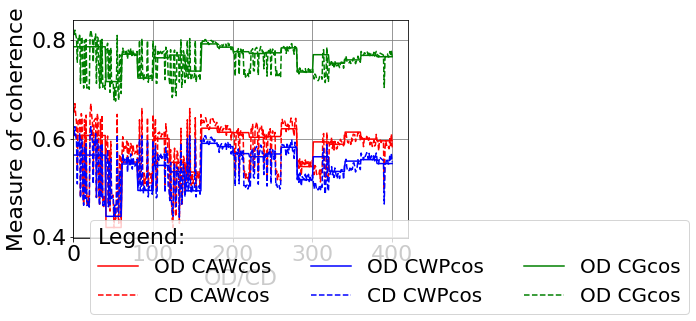

In [149]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [150]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 13.423027713461314
Diferença entre as equação CWP      : 10.202692001483252
Diferença entre as equação CG       : 7.3044667354945885


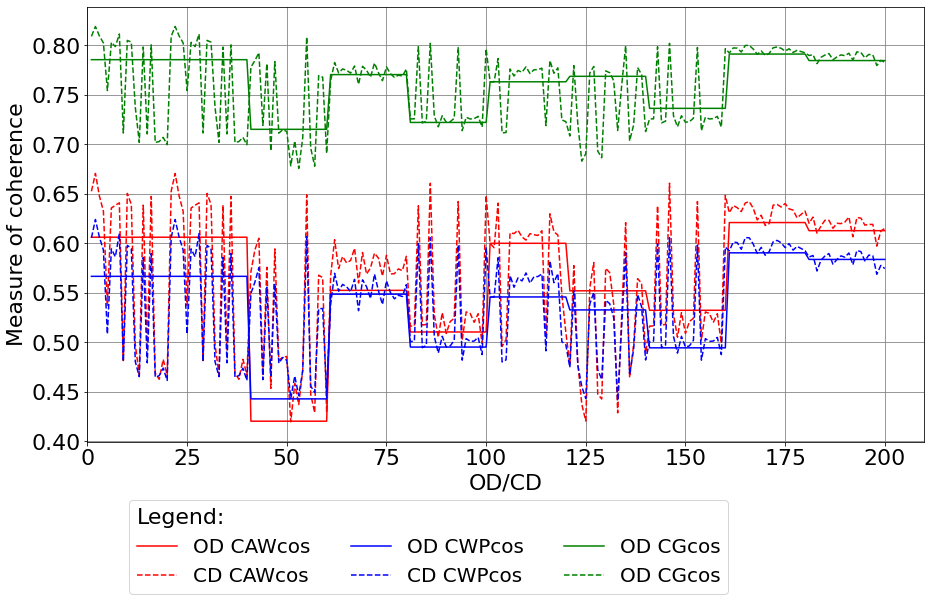

In [151]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

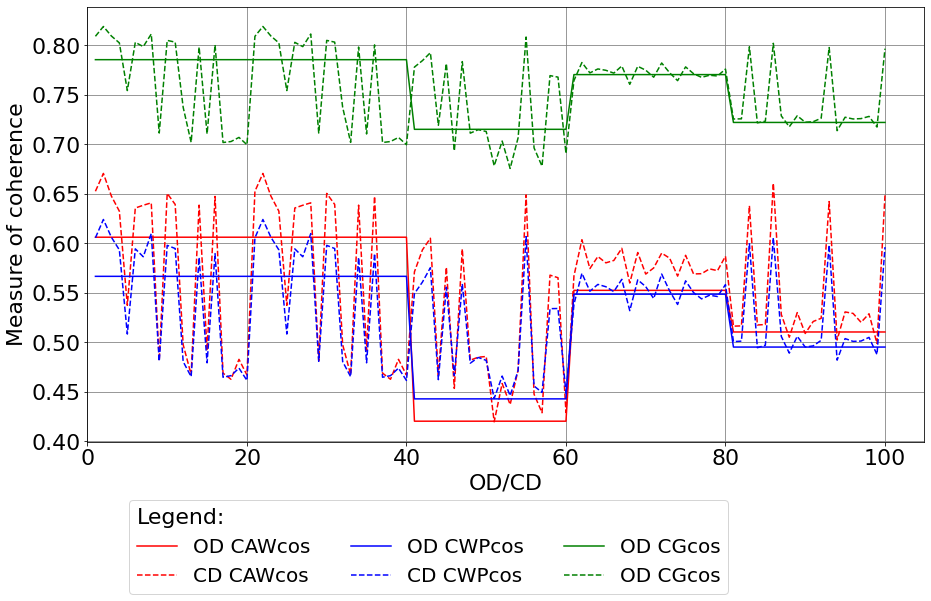

In [152]:

graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

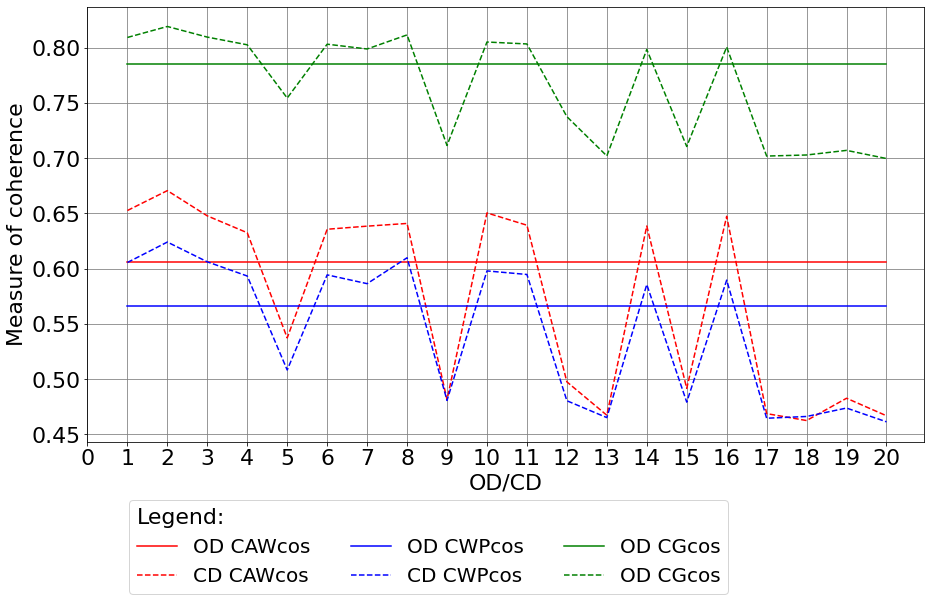

In [153]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

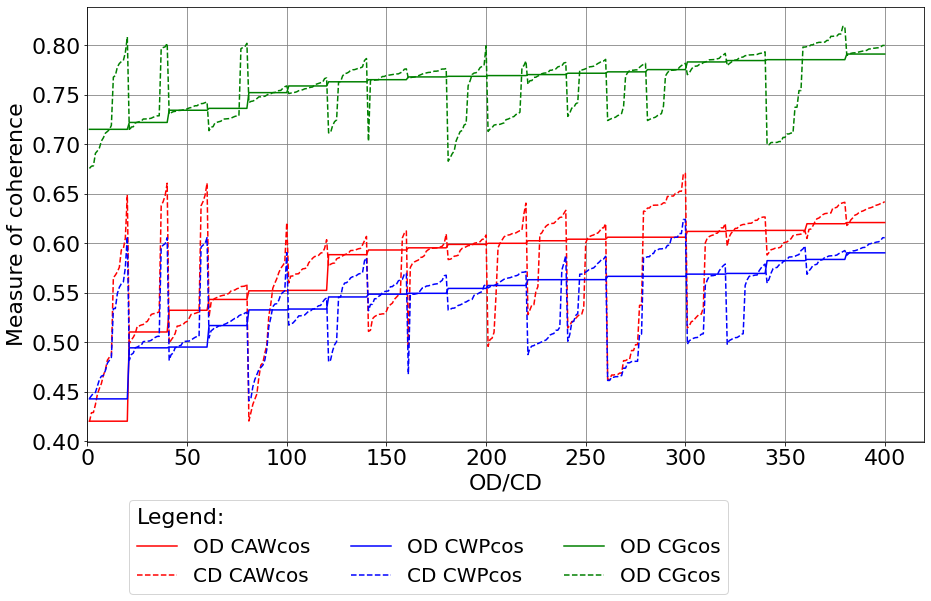

In [154]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

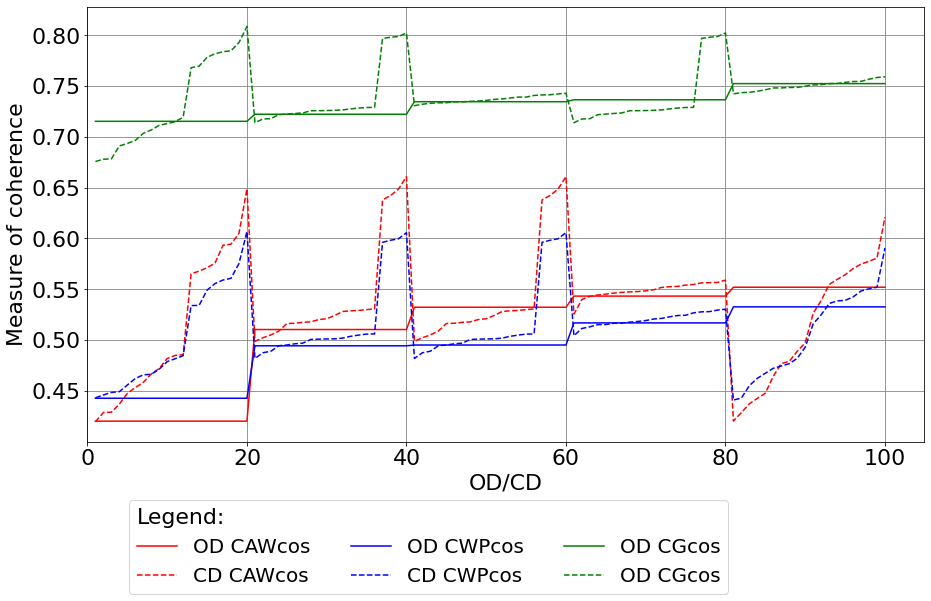

In [155]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

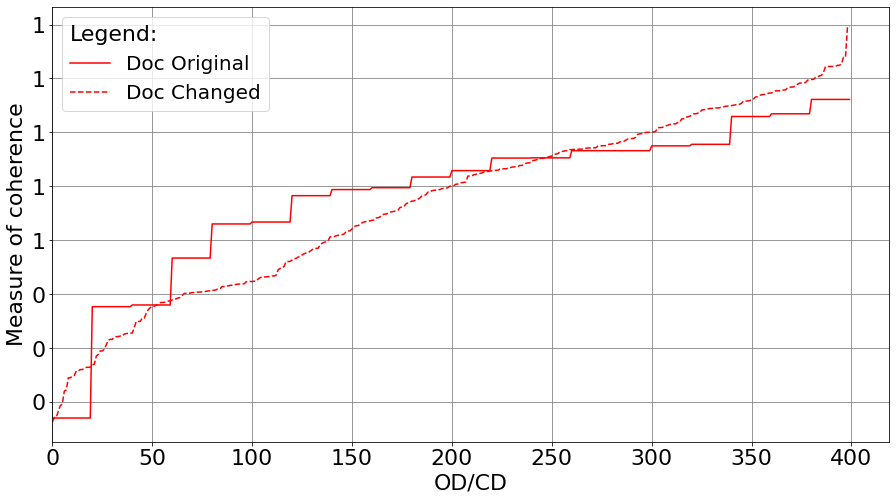

In [156]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

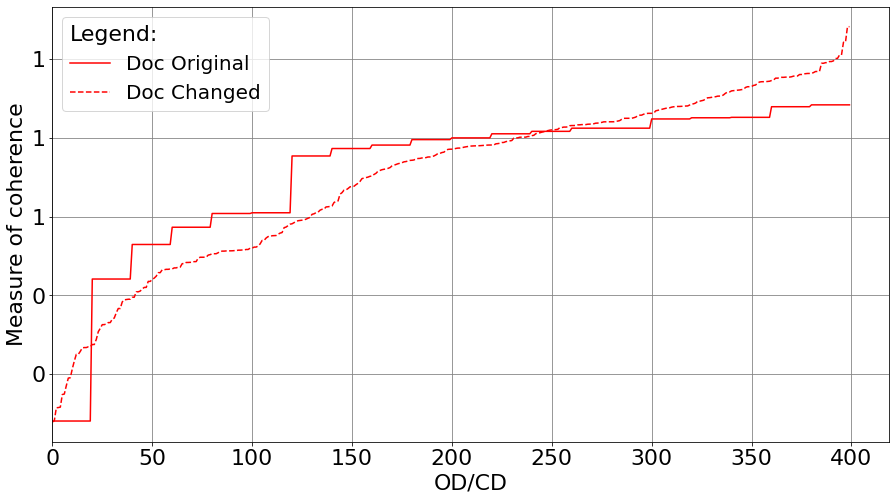

In [157]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

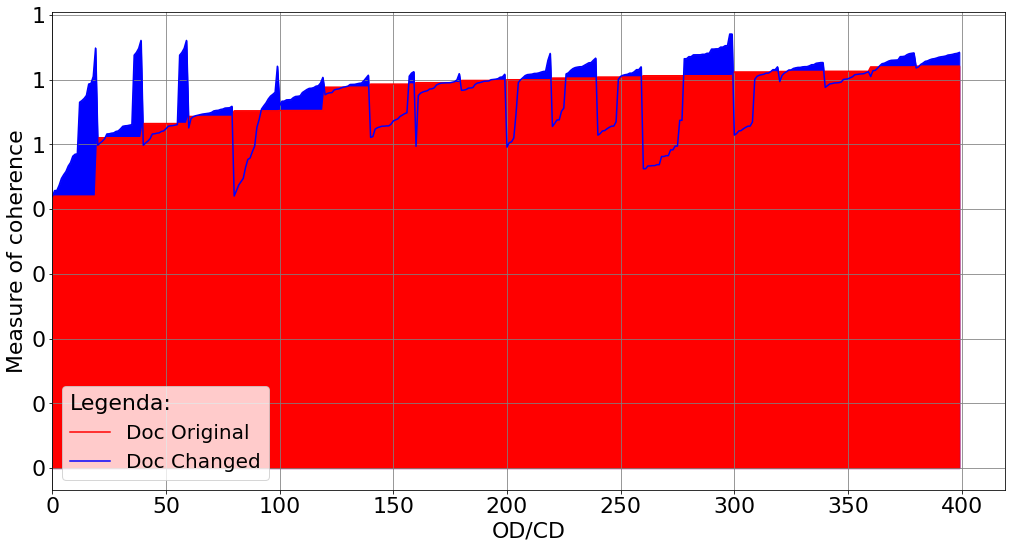

In [158]:
graficoLinhaMedida2Preenchido('Measure of coherence', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [159]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 13.423027713461314

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17p0', 0.1252024104961983, 7, 'How are the operations to push and pop elements in a queue implemented?']
['19p0', 0.12548798322677646, 10, 'In a stack does the enqueue operation occur at which end?']
['15p0', 0.15603745493960264, 4, 'What is a queue and how to push and pop its elements?']
['10p0', 0.157696688175201, 17, 'What is a stack and how to enqueue its element?']
['20p0', 0.2289134575562049, 9, 'In a queue does the push operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 1.0894525581194716, 8, 'What is a stack and how to enqueue and dequeue its elements?']
['7p0', 1.1621117067656348, 5, 'How to pop elements from a queue?']
['1p0', 1.525859879595893, 14, 'Ho

##### Usando CAW onde Cm(pertDO)>Cm(DO) *


In [160]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 5.920143458790353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.01550743232170737, 16, 'What is a stack and how to dequeue an element in it?']
['20p0', 0.02078902721404996, 9, 'In a queue does the push operation occur at which end?']
['19p0', 0.02751395648176036, 10, 'In a stack does the enqueue operation occur at which end?']
['16p0', 0.04833625008662523, 8, 'What is a stack and how to enqueue and dequeue its elements?']
['13p0', 0.07081775367259968, 13, 'What is a stack and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 0.42646733777863666, 15, 'How to dequeue elements in a stack?']
['8p0',

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [161]:
# id_documento = "3p0"
id_documento = lista[-1:][0][0]

In [162]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(>CAWcos(DO)=0,4201182744) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> move(>CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> process(>CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> connect(>CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> rank(>CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> sort(>CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> position(>CAWcos(pertDO)=0,4582101437)] - VERB/VERB-1-0
  

In [163]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;place;VERB;0,5710570642;0,5491354689;0,7780830413;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;arrange;VERB;0,5932505642;0,5606968190;0,7845610082;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;organize;VERB;0,6050297448;0,5752453761;0,7926375419;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;manage;VERB;0,4665834860;0,4621098174;0,7191540375;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [164]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 7.502884254670975

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['3p0', 0.0006427583949906168, 1, 'How to push elements in a queue?']
['9p0', 0.004135400056838878, 20, 'What is a queue and how to push its element?']
['15p0', 0.02137952746124938, 4, 'What is a queue and how to push and pop its elements?']
['10p0', 0.024733662605285867, 17, 'What is a stack and how to enqueue its element?']
['5p0', 0.026499284871129458, 2, 'How to push elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.8275155518009948, 16, 'What is a stack and how to dequeue an element in it?']
['7p0', 0.9753951417016131, 5, 'How to po

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [165]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [166]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(>CAWcos(DO)=0,4201182744) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> move(>CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> process(>CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> connect(>CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> rank(>CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> sort(>CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> position(>CAWcos(pertDO)=0,4582101437)] - VERB/VERB-1-0
  

In [167]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;place;VERB;0,5710570642;0,5491354689;0,7780830413;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;arrange;VERB;0,5932505642;0,5606968190;0,7845610082;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;organize;VERB;0,6050297448;0,5752453761;0,7926375419;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;manage;VERB;0,4665834860;0,4621098174;0,7191540375;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

#### Usando CWP

In [168]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 10.202692001483252

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10p0', 0.1076862313530661, 19, 'What is a stack and how to enqueue its element?']
['15p0', 0.11727666215730825, 4, 'What is a queue and how to push and pop its elements?']
['19p0', 0.13599157649459326, 11, 'In a stack does the enqueue operation occur at which end?']
['17p0', 0.1383809863211034, 6, 'How are the operations to push and pop elements in a queue implemented?']
['9p0', 0.14027795629067852, 20, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 0.819616545532232, 5, 'How to pop elements from a queue?']
['16p0', 1.0823630083185165, 12, 'What is a stack and how to enqueue and dequeue its elements?']
['3p0', 1.1732515428947008, 1, 'How to 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [169]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 4.372347765181557

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.006584952493290275, 10, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['11p0', 0.02544789474744036, 17, 'What is a stack and how to dequeue an element in it?']
['13p0', 0.028315645379897614, 16, 'What is a stack and how to enqueue an element in it?']
['17p0', 0.03702906167114184, 6, 'How are the operations to push and pop elements in a queue implemented?']
['16p0', 0.05045165580052591, 12, 'What is a stack and how to enqueue and dequeue its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 0.35492016055754294, 14, 'H

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [170]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [171]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(CWPcos(DO)=0,4426747426) -> order(>CWPcos(pertDO)=0,4430822483)] - VERB/VERB-1-0
  2 - How to connect elements in a queue ? [push(CWPcos(DO)=0,4426747426) -> connect(>CWPcos(pertDO)=0,4458809450)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CWPcos(DO)=0,4426747426) -> process(>CWPcos(pertDO)=0,4484263309)] - VERB/VERB-1-0
  4 - How to move elements in a queue ? [push(CWPcos(DO)=0,4426747426) -> move(>CWPcos(pertDO)=0,4491421245)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CWPcos(DO)=0,4426747426) -> rank(>CWPcos(pertDO)=0,4556849701)] - VERB/VERB-1-0
  6 - How to manage elements in a queue ? [push(CWPcos(DO)=0,4426747426) -> manage(>CWPcos(pertDO)=0,4621098174)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CWPcos(DO)=0,4426747426) -> position(>CWPcos(pertDO)=0,4657043360)] - VERB/VERB-1-

In [172]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;place;VERB;0,5710570642;0,5491354689;0,7780830413;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;arrange;VERB;0,5932505642;0,5606968190;0,7845610082;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;organize;VERB;0,6050297448;0,5752453761;0,7926375419;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;manage;VERB;0,4665834860;0,4621098174;0,7191540375;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [173]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 5.830344236301698

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.0029969464648853528, 20, 'What is a queue and how to push its element?']
['19p0', 0.004426009727246716, 11, 'In a stack does the enqueue operation occur at which end?']
['8p0', 0.02460715692593829, 2, 'How to pop elements in a queue data structure?']
['15p0', 0.025594505561643777, 4, 'What is a queue and how to push and pop its elements?']
['5p0', 0.027619359357696605, 3, 'How to push elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.6170195792115133, 17, 'What is a stack and how to dequeue an element in it?']
['7p0', 0.6838

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [174]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [175]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9p0
DO: What is a queue and how to push its element?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB PRON NOUN PUNCT 
  1 - What is a queue and how to select its element ? [push(>CWPcos(DO)=0,5902972991) -> select(CWPcos(pertDO)=0,5878535964)] - VERB/VERB-1-0
  2 - What is a queue and how to retrieve its element ? [push(>CWPcos(DO)=0,5902972991) -> retrieve(CWPcos(pertDO)=0,5897440553)] - VERB/VERB-1-0
  3 - What is a queue and how to choose its element ? [push(CWPcos(DO)=0,5902972991) -> choose(>CWPcos(pertDO)=0,5914622388)] - VERB/VERB-1-0
  4 - What is a queue and how to find its element ? [push(CWPcos(DO)=0,5902972991) -> find(>CWPcos(pertDO)=0,5922298242)] - VERB/VERB-1-0
  5 - What is a queue and how to obtain its element ? [push(CWPcos(DO)=0,5902972991) -> obtain(>CWPcos(pertDO)=0,5924321505)] - VERB/VERB-1-0
  6 - What is a queue and how to get its element ? [push(CWPcos(DO)=0,5902972991) -> get(>CWPcos(pertDO)=0,5930550890)] - VERB/VERB-1-0
  7 - What is a queue and how to

In [176]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9p0
DO: What is a queue and how to push its element?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
9p0_pert_0;What is a queue and how to find its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;find;VERB;0,6308034658;0,5922298242;0,7923665534;0,1552673429;0;1
9p0_pert_1;What is a queue and how to use its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;use;VERB;0,6380981863;0,6012190857;0,7974636230;0,0824531317;0;1
9p0_pert_2;What is a queue and how to access its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;access;VERB;0,6359074712;0,6006354364;0,7971898588;0,0643965825;0;1
9p0_pert_3;What is a queue and how to manage its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;manage;VERB;0,6319881678;0,5938679966;0,7932965972;0,0600575954;0;1

#### Usando CG

In [177]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 7.3044667354945885

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15p0', 0.06607772025409575, 3, 'What is a queue and how to push and pop its elements?']
['9p0', 0.08005757765336396, 20, 'What is a queue and how to push its element?']
['19p0', 0.08082911372184787, 9, 'In a stack does the enqueue operation occur at which end?']
['17p0', 0.08472128425325676, 5, 'How are the operations to push and pop elements in a queue implemented?']
['18p0', 0.08536956139973195, 6, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 0.7443654264789075, 10, 'How to pop elements from a queue?']
['3p0', 0.7545841427345295, 1, 'How to push elements in a queue?']
['16p0', 0.821395985782147, 11, 'What 

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [178]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 2.568819990476871

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.018014632738553527, 15, 'What is a stack and how to dequeue an element in it?']
['17p0', 0.02271163889340022, 5, 'How are the operations to push and pop elements in a queue implemented?']
['18p0', 0.028629396642957716, 6, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['16p0', 0.032881590036245245, 11, 'What is a stack and how to enqueue and dequeue its elements?']
['13p0', 0.03568748785899223, 14, 'What is a stack and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 0.21965857595205307, 18, 'How

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [179]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [180]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to connect elements in a queue ? [push(>CGcos(DO)=0,7151520103) -> connect(CGcos(pertDO)=0,6756190739)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(>CGcos(DO)=0,7151520103) -> move(CGcos(pertDO)=0,6778531636)] - VERB/VERB-1-0
  3 - How to order elements in a queue ? [push(>CGcos(DO)=0,7151520103) -> order(CGcos(pertDO)=0,6782135242)] - VERB/VERB-1-0
  4 - How to process elements in a queue ? [push(>CGcos(DO)=0,7151520103) -> process(CGcos(pertDO)=0,6908862703)] - VERB/VERB-1-0
  5 - How to sort elements in a queue ? [push(>CGcos(DO)=0,7151520103) -> sort(CGcos(pertDO)=0,6933517859)] - VERB/VERB-1-0
  6 - How to rank elements in a queue ? [push(>CGcos(DO)=0,7151520103) -> rank(CGcos(pertDO)=0,6963787840)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(>CGcos(DO)=0,7151520103) -> position(CGcos(pertDO)=0,7033154359)] - VERB/VERB-1-0
  8 - How to han

In [181]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;place;VERB;0,5710570642;0,5491354689;0,7780830413;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;arrange;VERB;0,5932505642;0,5606968190;0,7845610082;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;organize;VERB;0,6050297448;0,5752453761;0,7926375419;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;manage;VERB;0,4665834860;0,4621098174;0,7191540375;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [182]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 4.735646745017719

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.0016779140992598807, 20, 'What is a queue and how to push its element?']
['19p0', 0.0026886711517968287, 9, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.00988537073135387, 17, 'What is a stack and how to enqueue its element?']
['15p0', 0.010197618999742142, 3, 'What is a queue and how to push and pop its elements?']
['5p0', 0.017757663130760104, 2, 'How to push elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.4343731982203629, 15, 'What is a stack and how to dequeue an element in it?']
['1p0', 0.643

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [183]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [184]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9p0
DO: What is a queue and how to push its element?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB PRON NOUN PUNCT 
  1 - What is a queue and how to select its element ? [push(>CGcos(DO)=0,7912440463) -> select(CGcos(pertDO)=0,7898395928)] - VERB/VERB-1-0
  2 - What is a queue and how to retrieve its element ? [push(>CGcos(DO)=0,7912440463) -> retrieve(CGcos(pertDO)=0,7909705856)] - VERB/VERB-1-0
  3 - What is a queue and how to choose its element ? [push(CGcos(DO)=0,7912440463) -> choose(>CGcos(pertDO)=0,7919049371)] - VERB/VERB-1-0
  4 - What is a queue and how to find its element ? [push(CGcos(DO)=0,7912440463) -> find(>CGcos(pertDO)=0,7923665534)] - VERB/VERB-1-0
  5 - What is a queue and how to obtain its element ? [push(CGcos(DO)=0,7912440463) -> obtain(>CGcos(pertDO)=0,7924971689)] - VERB/VERB-1-0
  6 - What is a queue and how to get its element ? [push(CGcos(DO)=0,7912440463) -> get(>CGcos(pertDO)=0,7928209251)] - VERB/VERB-1-0
  7 - What is a queue and how to manage its 

In [185]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9p0
DO: What is a queue and how to push its element?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
9p0_pert_0;What is a queue and how to find its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;find;VERB;0,6308034658;0,5922298242;0,7923665534;0,1552673429;0;1
9p0_pert_1;What is a queue and how to use its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;use;VERB;0,6380981863;0,6012190857;0,7974636230;0,0824531317;0;1
9p0_pert_2;What is a queue and how to access its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;access;VERB;0,6359074712;0,6006354364;0,7971898588;0,0643965825;0;1
9p0_pert_3;What is a queue and how to manage its element ?;push;VERB;0,6209073126;0,5902972991;0,7912440463;manage;VERB;0,6319881678;0,5938679966;0,7932965972;0,0600575954;0;1

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [186]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 4.735646745017719

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19p0', 0.015336061065847284, 10, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.015657290816307068, 17, 'What is a stack and how to enqueue its element?']
['15p0', 0.01771311289242783, 4, 'What is a queue and how to push and pop its elements?']
['17p0', 0.01845429952328026, 7, 'How are the operations to push and pop elements in a queue implemented?']
['9p0', 0.0211719989776612, 20, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 0.13161827144878252, 5, 'How to pop elements from a queue?']
['1p0', 0.14362994049276628, 14, 'How to dequeue elements in a stack?']
['2p0', 0.

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [187]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 4.735646745017719

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.007941357791423798, 16, 'What is a stack and how to dequeue an element in it?']
['19p0', 0.009541628035632077, 10, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.013812500238418512, 17, 'What is a stack and how to enqueue its element?']
['20p0', 0.013967671177603891, 9, 'In a queue does the push operation occur at which end?']
['15p0', 0.015715278685092926, 4, 'What is a queue and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 0.06445746762411941, 15, 'How to dequeue elements in a stack?']
['7p0', 0.06891060301235

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [188]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [189]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(>CAWcos(DO)=0,4201182744) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> move(>CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> process(>CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> connect(>CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> rank(>CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> sort(>CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> position(>CAWcos(pertDO)=0,4582101437)] - VERB/VERB-1-0
  

In [190]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;place;VERB;0,5710570642;0,5491354689;0,7780830413;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;arrange;VERB;0,5932505642;0,5606968190;0,7845610082;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;organize;VERB;0,6050297448;0,5752453761;0,7926375419;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;manage;VERB;0,4665834860;0,4621098174;0,7191540375;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [191]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 4.735646745017719

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['3p0', 0.0006427583949906168, 1, 'How to push elements in a queue?']
['9p0', 0.002923977375030473, 20, 'What is a queue and how to push its element?']
['5p0', 0.011557011968559683, 2, 'How to push elements in a queue data structure?']
['17p0', 0.0117570482767545, 7, 'How are the operations to push and pop elements in a queue implemented?']
['14p0', 0.014875344932079315, 19, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20p0', 0.09830080243674194, 9, 'In a queue does the push operation occur at which end?']
['6p0', 0.10417874961752788, 1

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [192]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [193]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> order(CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> find(CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> separate(CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> connect(CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> sort(CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> create(CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> manipulate(CAWcos(pertDO)

In [194]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
2p0_pert_0;How to arrange elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;arrange;VERB;0,6525400536;0,6054948622;0,8091780990;0,1123573184;0;1
2p0_pert_1;How to organize elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;organize;VERB;0,6705504145;0,6239989198;0,8191115409;0,1085551530;0;1
2p0_pert_2;How to store elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;store;VERB;0,6476989388;0,6060953225;0,8094890267;0,0565749370;0;1
2p0_pert_3;How to put elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;put;VERB;0,6324272156;0,5932627363;0,8025276959;0,0434137173;0;1
2p0_pert_4;How to manage elements in a stack ?;deque

#### Usando CWP






In [195]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 4.735646745017719

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15p0', 0.013506296448982713, 4, 'What is a queue and how to push and pop its elements?']
['19p0', 0.014103910236647699, 11, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.015017429265108961, 19, 'What is a stack and how to enqueue its element?']
['9p0', 0.015319946679202001, 20, 'What is a queue and how to push its element?']
['17p0', 0.01626451428119946, 6, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 0.10524938415203777, 14, 'How to dequeue elements in a stack?']
['2p0', 0.10524938415203777, 15, 'How to dequeue elements in a stack?']
['5p

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [196]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 4.735646745017719

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.003781843971420118, 10, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['10p0', 0.00899190306663511, 19, 'What is a stack and how to enqueue its element?']
['11p0', 0.009460702156409151, 17, 'What is a stack and how to dequeue an element in it?']
['13p0', 0.010177639814523465, 16, 'What is a stack and how to enqueue an element in it?']
['17p0', 0.011155825067352465, 6, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 0.057454032557351264, 15, 'How to dequeue elements 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [197]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [198]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(>CAWcos(DO)=0,4201182744) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> move(>CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> process(>CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> connect(>CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> rank(>CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> sort(>CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> position(>CAWcos(pertDO)=0,4582101437)] - VERB/VERB-1-0
  

In [199]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;place;VERB;0,5710570642;0,5491354689;0,7780830413;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;arrange;VERB;0,5932505642;0,5606968190;0,7845610082;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;organize;VERB;0,6050297448;0,5752453761;0,7926375419;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;manage;VERB;0,4665834860;0,4621098174;0,7191540375;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [200]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 4.735646745017719

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.0024437026544050777, 20, 'What is a queue and how to push its element?']
['19p0', 0.002521100820917055, 11, 'In a stack does the enqueue operation occur at which end?']
['8p0', 0.012440763046551118, 2, 'How to pop elements in a queue data structure?']
['15p0', 0.012585607822611311, 4, 'What is a queue and how to push and pop its elements?']
['5p0', 0.013222582767614122, 3, 'How to push elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 0.07569797556751812, 12, 'What is a stack and how to enqueue and dequeue its elements?']
['20p0', 0.081837

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [201]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [202]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> order(CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> find(CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> separate(CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> connect(CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> sort(CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> create(CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> manipulate(CAWcos(pertDO)

In [203]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
2p0_pert_0;How to arrange elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;arrange;VERB;0,6525400536;0,6054948622;0,8091780990;0,1123573184;0;1
2p0_pert_1;How to organize elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;organize;VERB;0,6705504145;0,6239989198;0,8191115409;0,1085551530;0;1
2p0_pert_2;How to store elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;store;VERB;0,6476989388;0,6060953225;0,8094890267;0,0565749370;0;1
2p0_pert_3;How to put elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;put;VERB;0,6324272156;0,5932627363;0,8025276959;0,0434137173;0;1
2p0_pert_4;How to manage elements in a stack ?;deque

#### Usando CG






In [204]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 4.735646745017719

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.008141249418258667, 6, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['15p0', 0.008353535945598956, 3, 'What is a queue and how to push and pop its elements?']
['19p0', 0.008417516946792603, 9, 'In a stack does the enqueue operation occur at which end?']
['9p0', 0.008727994832125496, 20, 'What is a queue and how to push its element?']
['10p0', 0.008805887265638801, 17, 'What is a stack and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.07998135164380071, 2, 'How to push elements in a queue data structure?']
['7p0', 0.08579870290122926, 10, 'How to pop elements from a

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [205]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 4.735646745017719

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.006338110336890579, 15, 'What is a stack and how to dequeue an element in it?']
['17p0', 0.0067843539374216055, 5, 'How are the operations to push and pop elements in a queue implemented?']
['18p0', 0.008141249418258667, 6, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['15p0', 0.008353535945598956, 3, 'What is a queue and how to push and pop its elements?']
['19p0', 0.008417516946792603, 9, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 0.03355412185192108, 18, 'How to dequeue el

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [206]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [207]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(>CAWcos(DO)=0,4201182744) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> move(>CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> process(>CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> connect(>CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> rank(>CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> sort(>CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> position(>CAWcos(pertDO)=0,4582101437)] - VERB/VERB-1-0
  

In [208]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;place;VERB;0,5710570642;0,5491354689;0,7780830413;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;arrange;VERB;0,5932505642;0,5606968190;0,7845610082;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;organize;VERB;0,6050297448;0,5752453761;0,7926375419;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520103;manage;VERB;0,4665834860;0,4621098174;0,7191540375;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [209]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 4.735646745017719

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.0014044534076343984, 20, 'What is a queue and how to push its element?']
['19p0', 0.0015224119027454908, 9, 'In a stack does the enqueue operation occur at which end?']
['15p0', 0.003875911402596688, 3, 'What is a queue and how to push and pop its elements?']
['10p0', 0.0050697922706604, 17, 'What is a stack and how to enqueue its element?']
['18p0', 0.007710793188639986, 6, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 0.05643984274222302, 11, 'What is a stack and how to enqueue and dequeue it

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [210]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [211]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> order(CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> find(CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> separate(CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> connect(CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> sort(CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> create(CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [dequeue(>CAWcos(DO)=0,6060929469) -> manipulate(CAWcos(pertDO)

In [212]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
2p0_pert_0;How to arrange elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;arrange;VERB;0,6525400536;0,6054948622;0,8091780990;0,1123573184;0;1
2p0_pert_1;How to organize elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;organize;VERB;0,6705504145;0,6239989198;0,8191115409;0,1085551530;0;1
2p0_pert_2;How to store elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;store;VERB;0,6476989388;0,6060953225;0,8094890267;0,0565749370;0;1
2p0_pert_3;How to put elements in a stack ?;dequeue;VERB;0,6060929469;0,5665448872;0,7855574191;put;VERB;0,6324272156;0,5932627363;0,8025276959;0,0434137173;0;1
2p0_pert_4;How to manage elements in a stack ?;deque

## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [213]:
medida = 'euc'

### Estatística

#### CAW

In [214]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 205 de 400
Percentual de documentos coerentes em relação ao total: 51.24999999999999
Acertos Perturbado : 195 de 400
Percentual de documentos incoerentes em relação ao total: 48.75


#### CWP

In [215]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 218 de 400
Percentual de documentos coerentes em relação ao total: 54.50000000000001
Acertos Perturbado : 182 de 400
Percentual de documentos incoerentes em relação ao total: 45.5


#### CG

In [216]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 200 de 400
Percentual de documentos coerentes em relação ao total: 50.0
Acertos Perturbado : 200 de 400
Percentual de documentos incoerentes em relação ao total: 50.0


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [217]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [218]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1p0;How to connect elements in a stack ?
2p0;How to order elements in a stack ?
3p0;How to order elements in a queue ?
4p0;How to jazz and pop elements in a queue ?
5p0;How to sort elements in a queue data structure ?
6p0;How to load and pop elements in a queue data structure ?
7p0;How to select elements from a queue ?
8p0;How to order elements in a queue data structure ?
9p0;What is a queue and how to select its element ?
10p0;What is a stack and how to count its element ?
11p0;What is a stack and how to locate an element in it ?
12p0;What is a queue and how to select an element from it ?
13p0;What is a stack and how to sort an element in it ?
14p0;What is a queue and how to set an element on it ?
15p0;What is a queue and how to separate and pop its elements ?
16p0;What is a stack and how to enqueue and store its elements ?
17p0;How are the operations to push and pop elements in a queue related ?
18p0;How are the operations to list and dequeue elements in a stack implemented ?
19p0;In

### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





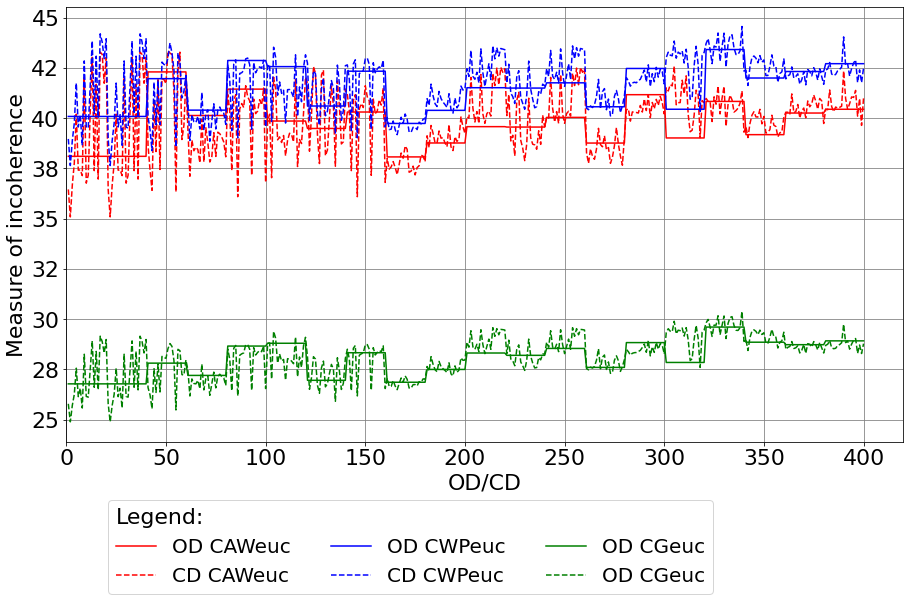

In [219]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [220]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 462.06253419632174
Diferença absoluta entre as medidas equação CWP : 360.5003045812933
Diferença absoluta entre as medidas equação CG  : 222.8778473669556


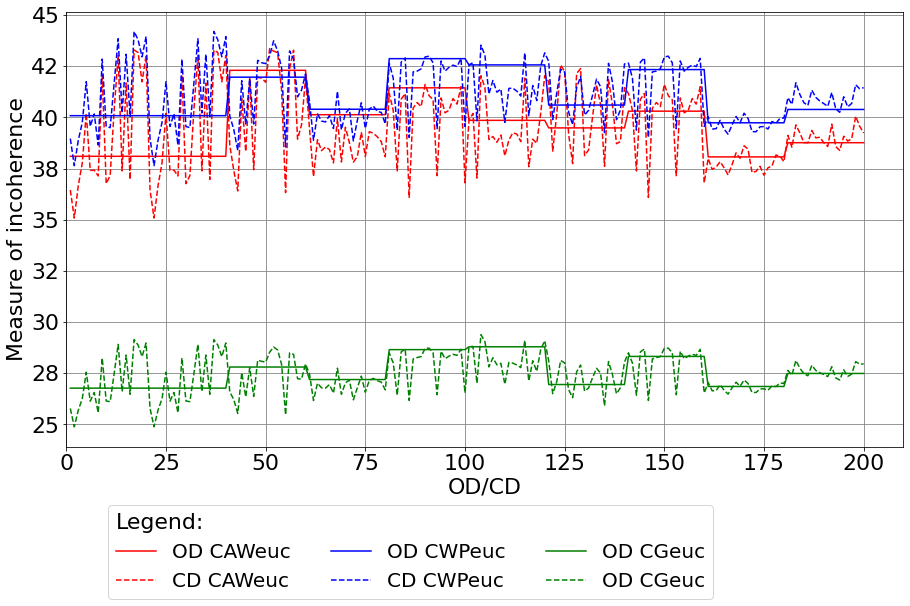

In [221]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

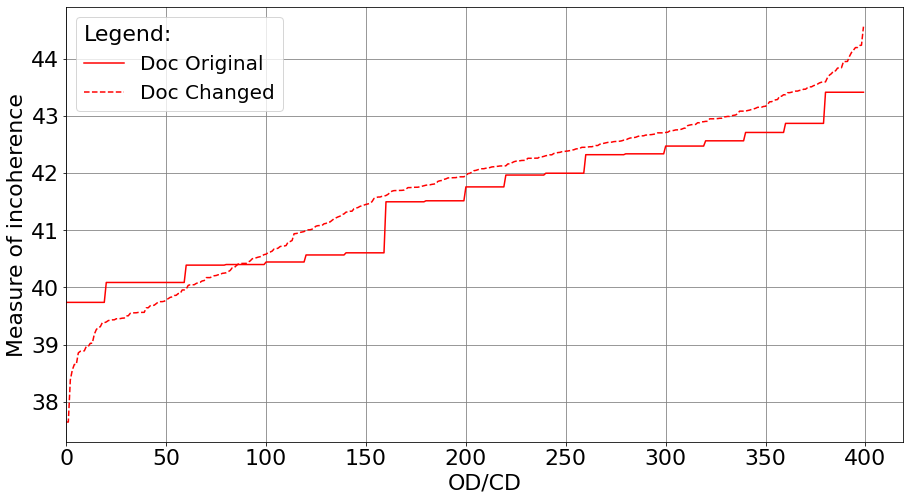

In [222]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

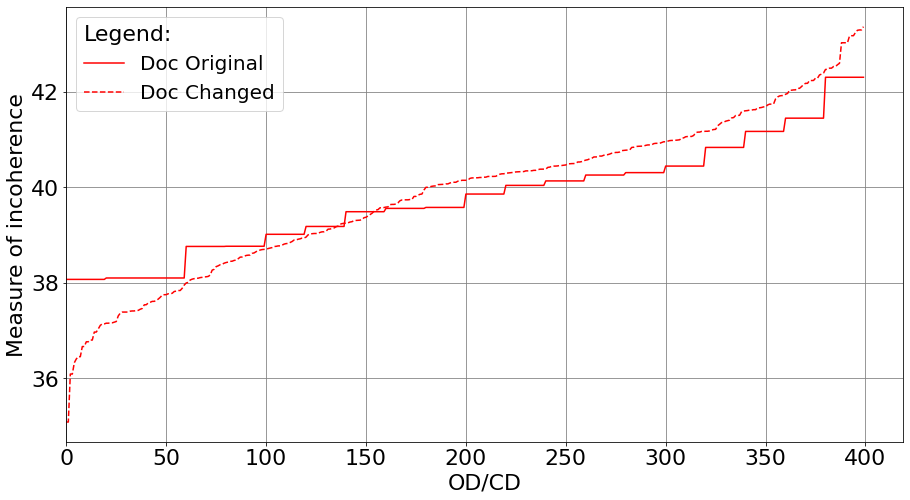

In [223]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

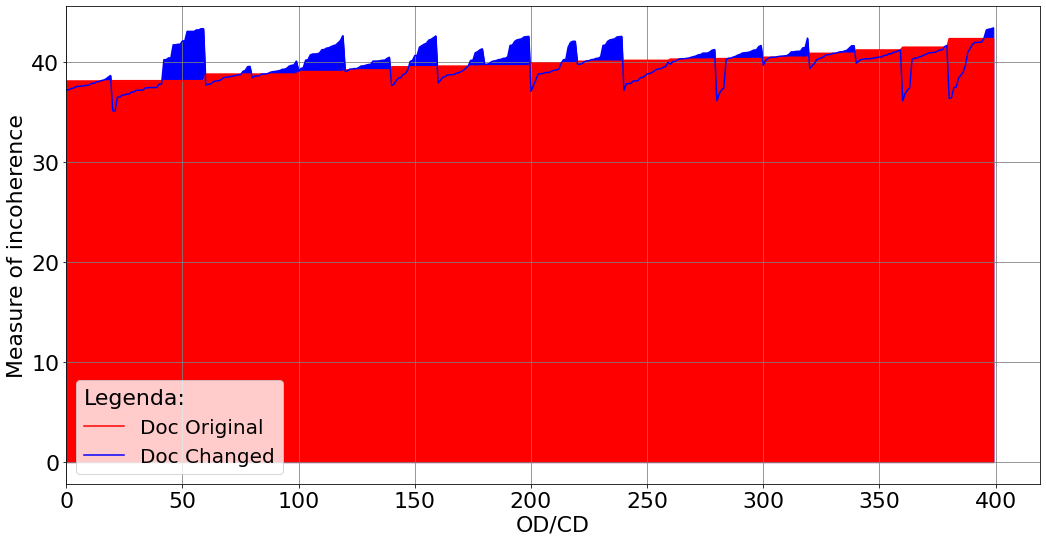

In [224]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

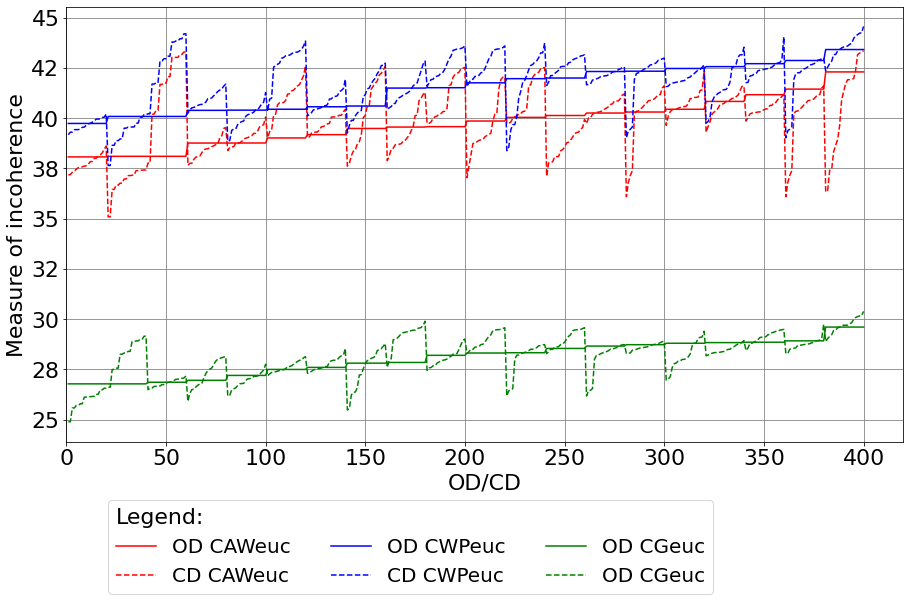

In [225]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [226]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 462.06253419632174
Diferença absoluta entre as medidas equação CWP : 360.5003045812933
Diferença absoluta entre as medidas equação CG  : 222.8778473669556


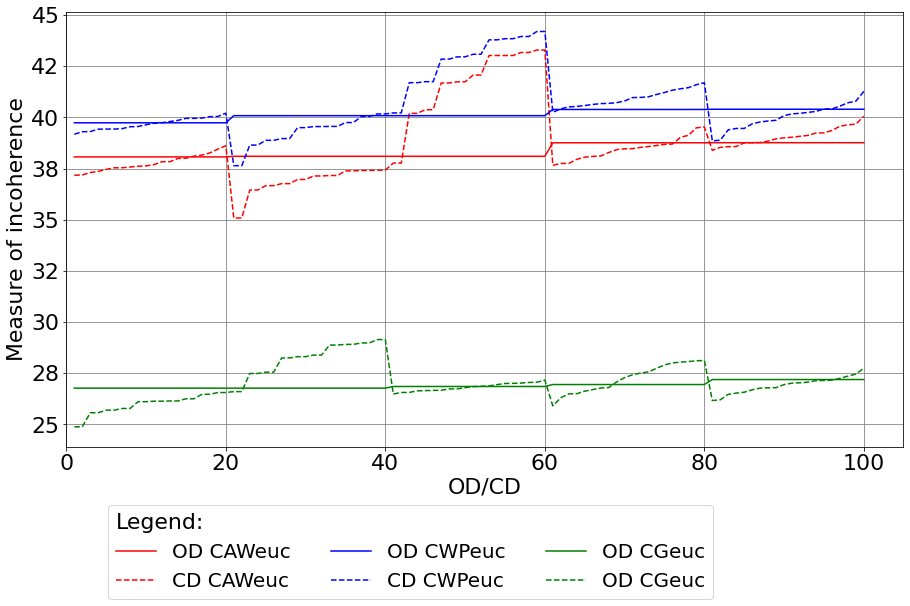

In [227]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

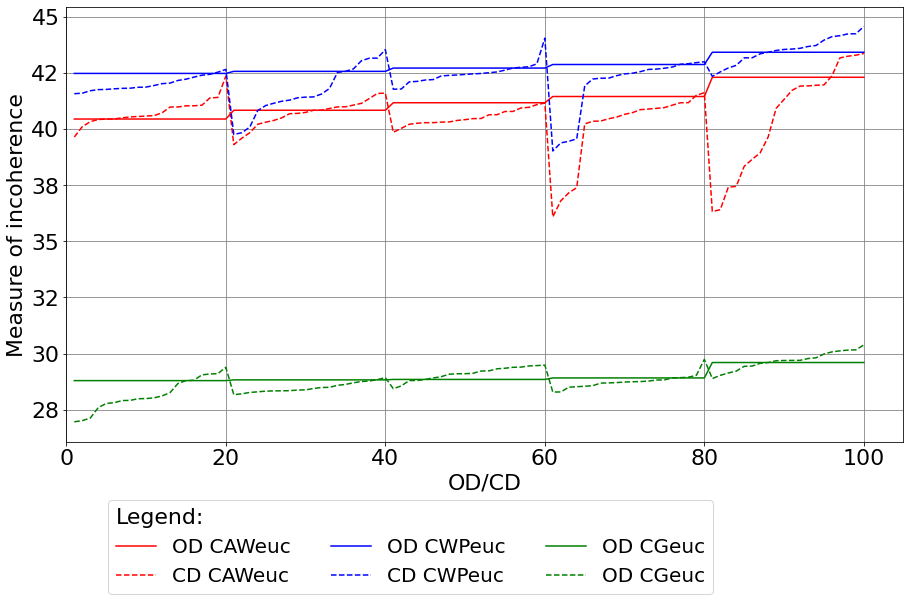

In [228]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

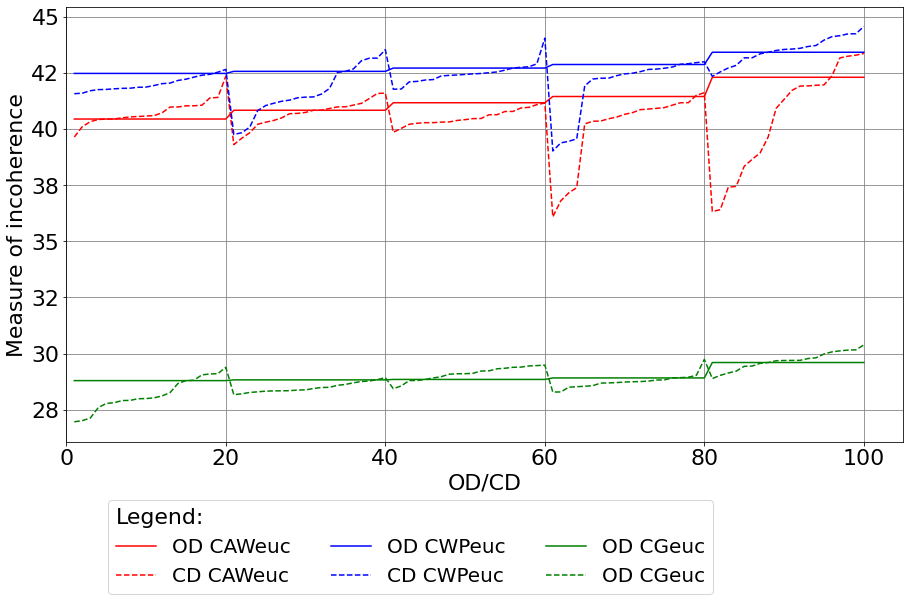

In [229]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

# DO central do gráfico com a maior diferença
# idDO = 3
# difabs= 66.91955484662748, 
# 'How to push elements in a stack?'
# Posição gráfico 18 * 20 = 360

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [230]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 462.06253419632174

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19p0', 7.360540216619256, 14, 'In a stack does the enqueue operation occur at which end?']
['10p0', 7.873362922668463, 5, 'What is a stack and how to enqueue its element?']
['9p0', 8.537097358703598, 1, 'What is a queue and how to push its element?']
['20p0', 8.777732502330416, 16, 'In a queue does the push operation occur at which end?']
['17p0', 9.070956743680512, 17, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 32.46185003008157, 8, 'How to pop elements from a queue?']
['16p0', 38.1860580444336, 6, 'What is a stack and how to enqueue and dequeue its elements?']
['3p0', 43.587788718087346, 20, 'How to push element

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [231]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 249.399808939263

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.22408252292209596, 19, 'How to push elements in a queue data structure?']
['9p0', 1.243262290954597, 1, 'What is a queue and how to push its element?']
['14p0', 2.13472509384156, 4, 'What is a queue and how to push an element on it?']
['17p0', 2.9591225844163205, 17, 'How are the operations to push and pop elements in a queue implemented?']
['3p0', 3.9081464494977496, 20, 'How to push elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 23.522317886352553, 8, 'How to pop elements from a queue?']
['11p0', 29.002158323923666, 10, 'What is a stack and 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [232]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [233]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to enqueue and stack its elements ? [dequeue(>CAWeuc(DO)=39,0158348083) -> stack(CAWeuc(pertDO)=39,0323685010)] - VERB/VERB-1-0
  2 - What is a stack and how to enqueue and preserve its elements ? [dequeue(>CAWeuc(DO)=39,0158348083) -> preserve(CAWeuc(pertDO)=39,3224685987)] - VERB/VERB-1-0
  3 - What is a stack and how to enqueue and use its elements ? [dequeue(>CAWeuc(DO)=39,0158348083) -> use(CAWeuc(pertDO)=39,4014608065)] - VERB/VERB-1-0
  4 - What is a stack and how to enqueue and link its elements ? [dequeue(>CAWeuc(DO)=39,0158348083) -> link(CAWeuc(pertDO)=40,1493719419)] - VERB/VERB-1-0
  5 - What is a stack and how to enqueue and manipulate its elements ? [dequeue(>CAWeuc(DO)=39,0158348083) -> manipulate(CAWeuc(pertDO)=40,1957540512)] - VERB/VERB-1-0
  6 - What is a stack and how to enqueue and modif

In [234]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16p0_pert_0;What is a stack and how to enqueue and organize its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;organize;VERB;41,5076324145;43,0191324674;29,3245936174;0,0726551339;0;1
16p0_pert_1;What is a stack and how to enqueue and combine its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;combine;VERB;41,3553013802;43,2841305366;29,5203666687;0,0444236547;0;1
16p0_pert_2;What is a stack and how to enqueue and arrange its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;arrange;VERB;41,6707134247;43,1363447629;29,3951311845;0,0423170514;0;1
16p0_pert_3;What is a stack and how to enqueue and manage it

##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [235]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 212.66272525705853

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.25886007455680726, 7, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['13p0', 0.8691040674845425, 12, 'What is a stack and how to enqueue an element in it?']
['10p0', 0.9867082595825281, 5, 'What is a stack and how to enqueue its element?']
['19p0', 1.0716299577192885, 14, 'In a stack does the enqueue operation occur at which end?']
['20p0', 1.285031058571569, 16, 'In a queue does the push operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8p0', 13.87188572353788, 15, 'How to pop elements in a queue data st

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [236]:
# id_documento = "1"
id_documento = lista[-1:][0][0]

In [237]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> put(>CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> place(>CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> group(>CAWeuc(pertDO)=38,9386874608)] - VERB/NOU

In [238]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;place;VERB;38,6523573739;40,0689068522;26,5881993771;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;arrange;VERB;37,4069557190;39,4187649318;26,2221987247;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;organize;VERB;36,4072355543;38,3811018808;25,5374314785;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;manage;VERB;40,9201338632;41,7962424414;27,5304932594;0,0467672087;0;1
3p0_pert_4;How to put elements in a q

#### Usando CWP

In [239]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 360.5003045812933

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 5.056249028986159, 1, 'What is a queue and how to push its element?']
['19p0', 5.350007692972788, 14, 'In a stack does the enqueue operation occur at which end?']
['20p0', 7.982234030058919, 18, 'In a queue does the push operation occur at which end?']
['14p0', 8.016204393827024, 7, 'What is a queue and how to push an element on it?']
['17p0', 9.637825745802637, 20, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6p0', 23.329460288539046, 17, 'How to push and pop elements in a queue data structure?']
['3p0', 26.923285348074756, 12, 'How to push elements in a queue?']
['1p0', 35.799094336373436, 2, 'How to dequeue ele

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [240]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 222.07696244915903

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15p0', 0.2352510109925774, 16, 'What is a queue and how to push and pop its elements?']
['5p0', 0.25208566453723336, 19, 'How to push elements in a queue data structure?']
['19p0', 0.6540323315244763, 14, 'In a stack does the enqueue operation occur at which end?']
['20p0', 1.6135854432077323, 18, 'In a queue does the push operation occur at which end?']
['4p0', 1.761677847968194, 5, 'How to push and pop elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13p0', 18.480871396187013, 11, 'What is a stack and how to enqueue an element in it?']
['11p0', 23.1628

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [241]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [242]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to enqueue and stack its elements ? [dequeue(CWPeuc(DO)=40,4449188159) -> stack(>CWPeuc(pertDO)=40,3411624370)] - VERB/VERB-1-0
  2 - What is a stack and how to enqueue and preserve its elements ? [dequeue(>CWPeuc(DO)=40,4449188159) -> preserve(CWPeuc(pertDO)=40,9431423530)] - VERB/VERB-1-0
  3 - What is a stack and how to enqueue and use its elements ? [dequeue(>CWPeuc(DO)=40,4449188159) -> use(CWPeuc(pertDO)=41,0026128475)] - VERB/VERB-1-0
  4 - What is a stack and how to enqueue and manipulate its elements ? [dequeue(>CWPeuc(DO)=40,4449188159) -> manipulate(CWPeuc(pertDO)=42,5388812530)] - VERB/VERB-1-0
  5 - What is a stack and how to enqueue and link its elements ? [dequeue(>CWPeuc(DO)=40,4449188159) -> link(CWPeuc(pertDO)=42,6231713417)] - VERB/VERB-1-0
  6 - What is a stack and how to enqueue and ident

In [243]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16p0_pert_0;What is a stack and how to enqueue and organize its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;organize;VERB;41,5076324145;43,0191324674;29,3245936174;0,0726551339;0;1
16p0_pert_1;What is a stack and how to enqueue and combine its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;combine;VERB;41,3553013802;43,2841305366;29,5203666687;0,0444236547;0;1
16p0_pert_2;What is a stack and how to enqueue and arrange its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;arrange;VERB;41,6707134247;43,1363447629;29,3951311845;0,0423170514;0;1
16p0_pert_3;What is a stack and how to enqueue and manage it

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [244]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 138.4233421321342

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16p0', 0.1037563788585274, 6, 'What is a stack and how to enqueue and dequeue its elements?']
['10p0', 0.13990898132324503, 4, 'What is a stack and how to enqueue its element?']
['13p0', 0.18268983792034987, 11, 'What is a stack and how to enqueue an element in it?']
['18p0', 0.5757146562848803, 13, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['14p0', 1.634960150107318, 7, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15p0', 9.502991431798762, 16, 'What is a queue and how to push and p

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [245]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [246]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to jam and pop elements in a queue data structure ? [push(CWPeuc(DO)=42,5666810816) -> jam(>CWPeuc(pertDO)=39,7574204532)] - VERB/VERB-1-0
  2 - How to pop and pop elements in a queue data structure ? [push(CWPeuc(DO)=42,5666810816) -> pop(>CWPeuc(pertDO)=39,8333717404)] - VERB/NOUN-0-0
  3 - How to try and pop elements in a queue data structure ? [push(CWPeuc(DO)=42,5666810816) -> try(>CWPeuc(pertDO)=40,0840283885)] - VERB/VERB-1-0
  4 - How to sit and pop elements in a queue data structure ? [push(CWPeuc(DO)=42,5666810816) -> sit(>CWPeuc(pertDO)=40,8208731160)] - VERB/VERB-1-0
  5 - How to throw and pop elements in a queue data structure ? [push(CWPeuc(DO)=42,5666810816) -> throw(>CWPeuc(pertDO)=41,0445760380)] - VERB/VERB-1-0
  6 - How to grab and pop elements in a queue data structure ? [push(CWPeuc(DO)=42,5666810816) -> grab(>CWPeuc(pe

In [247]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,7952829997;push;VERB;39,8584273945;42,5666810816;28,7952829997;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,7952829997;drag;VERB;40,1967116269;42,6758659247;28,8132942518;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,7952829997;pop;NOUN;37,0363127969;39,8333717404;27,0142765045;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,795

#### Usando CG

In [248]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 222.8778473669556

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 3.356390172784973, 3, 'What is a queue and how to push its element?']
['19p0', 3.4313262303670236, 15, 'In a stack does the enqueue operation occur at which end?']
['10p0', 4.762698086825285, 6, 'What is a stack and how to enqueue its element?']
['20p0', 5.259324868520121, 19, 'In a queue does the push operation occur at which end?']
['14p0', 5.566459655761719, 7, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6p0', 15.448813438415549, 16, 'How to push and pop elements in a queue data structure?']
['3p0', 16.747582435607903, 8, 'How to push elements in a queue?']
['1p0', 23.238832950592037, 1, 'How to dequeue elements in a stack?']
['2p0',

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [249]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 122.12414648708338

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15p0', 0.11133502079890434, 17, 'What is a queue and how to push and pop its elements?']
['5p0', 0.18076591491698224, 14, 'How to push elements in a queue data structure?']
['19p0', 0.4963981310526542, 15, 'In a stack does the enqueue operation occur at which end?']
['20p0', 0.9873943328857422, 19, 'In a queue does the push operation occur at which end?']
['4p0', 1.0449708938598654, 5, 'How to push and pop elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 9.468530654907216, 4, 'How to pop elements from a queue?']
['11p0', 13.39413466820347, 11, 'What 

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [250]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [251]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to enqueue and stack its elements ? [dequeue(CGeuc(DO)=27,8399325151) -> stack(>CGeuc(pertDO)=27,5916042328)] - VERB/VERB-1-0
  2 - What is a stack and how to enqueue and preserve its elements ? [dequeue(>CGeuc(DO)=27,8399325151) -> preserve(CGeuc(pertDO)=27,9329540546)] - VERB/VERB-1-0
  3 - What is a stack and how to enqueue and use its elements ? [dequeue(>CGeuc(DO)=27,8399325151) -> use(CGeuc(pertDO)=28,0270387209)] - VERB/VERB-1-0
  4 - What is a stack and how to enqueue and manipulate its elements ? [dequeue(>CGeuc(DO)=27,8399325151) -> manipulate(CGeuc(pertDO)=28,9756981776)] - VERB/VERB-1-0
  5 - What is a stack and how to enqueue and link its elements ? [dequeue(>CGeuc(DO)=27,8399325151) -> link(CGeuc(pertDO)=28,9906259683)] - VERB/VERB-1-0
  6 - What is a stack and how to enqueue and identify its el

In [252]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16p0_pert_0;What is a stack and how to enqueue and organize its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;organize;VERB;41,5076324145;43,0191324674;29,3245936174;0,0726551339;0;1
16p0_pert_1;What is a stack and how to enqueue and combine its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;combine;VERB;41,3553013802;43,2841305366;29,5203666687;0,0444236547;0;1
16p0_pert_2;What is a stack and how to enqueue and arrange its elements ?;dequeue;VERB;39,0158348083;40,4449188159;27,8399325151;arrange;VERB;41,6707134247;43,1363447629;29,3951311845;0,0423170514;0;1
16p0_pert_3;What is a stack and how to enqueue and manage it

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [253]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 100.75370087987217

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.030665324284480988, 11, 'What is a stack and how to dequeue an element in it?']
['16p0', 0.24832828228289827, 9, 'What is a stack and how to enqueue and dequeue its elements?']
['13p0', 0.5064485990084009, 13, 'What is a stack and how to enqueue an element in it?']
['18p0', 0.7997144971574848, 18, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['14p0', 1.126673771784862, 7, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 8.289363861083988, 2, 'How to dequeue elements in a stac

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [254]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [255]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to jam and pop elements in a queue data structure ? [push(CGeuc(DO)=28,7952829997) -> jam(>CGeuc(pertDO)=26,9603560766)] - VERB/VERB-1-0
  2 - How to pop and pop elements in a queue data structure ? [push(CGeuc(DO)=28,7952829997) -> pop(>CGeuc(pertDO)=27,0142765045)] - VERB/NOUN-0-0
  3 - How to try and pop elements in a queue data structure ? [push(CGeuc(DO)=28,7952829997) -> try(>CGeuc(pertDO)=27,1266932487)] - VERB/VERB-1-0
  4 - How to sit and pop elements in a queue data structure ? [push(CGeuc(DO)=28,7952829997) -> sit(>CGeuc(pertDO)=27,5917483966)] - VERB/VERB-1-0
  5 - How to throw and pop elements in a queue data structure ? [push(CGeuc(DO)=28,7952829997) -> throw(>CGeuc(pertDO)=27,7780687014)] - VERB/VERB-1-0
  6 - How to grab and pop elements in a queue data structure ? [push(CGeuc(DO)=28,7952829997) -> grab(>CGeuc(pertDO)=27,812

In [256]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,7952829997;push;VERB;39,8584273945;42,5666810816;28,7952829997;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,7952829997;drag;VERB;40,1967116269;42,6758659247;28,8132942518;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,7952829997;pop;NOUN;37,0363127969;39,8333717404;27,0142765045;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VERB;39,8584273945;42,5666810816;28,795

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [257]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 100.75370087987217

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.8949918746948242, 1, 'What is a queue and how to push its element?']
['19p0', 0.952776822176844, 14, 'In a stack does the enqueue operation occur at which end?']
['14p0', 1.1026581128438266, 4, 'What is a queue and how to push an element on it?']
['18p0', 1.2598404517540516, 7, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['10p0', 1.2951246261596694, 5, 'What is a stack and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8p0', 4.216232511732315, 15, 'How to pop elements in a queue data structure?']
['1p0', 5.192049298967625, 2, 'How to dequeue elements in a stack?']
['2p0'

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [258]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 100.75370087987217

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.16898473103841383, 19, 'How to push elements in a queue data structure?']
['9p0', 0.5447868347167955, 1, 'What is a queue and how to push its element?']
['17p0', 0.761597266564003, 17, 'How are the operations to push and pop elements in a queue implemented?']
['14p0', 0.7710056304931641, 4, 'What is a queue and how to push an element on it?']
['19p0', 0.952776822176844, 14, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11p0', 2.948796590169266, 10, 'What is a stack and how to dequeue an element in it?']
['7p0', 3.07670

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [259]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [260]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> combine(>C

In [261]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2p0_pert_0;How to arrange elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;arrange;VERB;36,4538773128;38,9668880190;25,7810781002;0,1123573184;0;1
2p0_pert_1;How to organize elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;organize;VERB;35,0861323220;37,6427433831;24,8844203949;0,1085551530;0;1
2p0_pert_2;How to store elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;store;VERB;36,6665782928;38,8817342349;25,6991417408;0,0565749370;0;1
2p0_pert_3;How to put elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;put;VERB;37,7712658473;39,7506514958;26,2543318272;0,0434137173;0;1
2p0_pert_4;How to manage ele

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [262]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 100.75370087987217

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.1469174898587795, 7, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['13p0', 0.30238914489745383, 12, 'What is a stack and how to enqueue an element in it?']
['10p0', 0.37793464660644815, 5, 'What is a stack and how to enqueue its element?']
['19p0', 0.5213050842285156, 14, 'In a stack does the enqueue operation occur at which end?']
['20p0', 0.8025443337180462, 16, 'In a queue does the push operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 3.0152508871896018, 3, 'How to dequeue elements in a stack?']
['4p0', 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [263]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [264]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> put(>CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> place(>CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [push(CAWeuc(DO)=42,3029752459) -> group(>CAWeuc(pertDO)=38,9386874608)] - VERB/NOU

In [265]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;place;VERB;38,6523573739;40,0689068522;26,5881993771;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;arrange;VERB;37,4069557190;39,4187649318;26,2221987247;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;organize;VERB;36,4072355543;38,3811018808;25,5374314785;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;42,3029752459;41,9673500742;27,8057658672;manage;VERB;40,9201338632;41,7962424414;27,5304932594;0,0467672087;0;1
3p0_pert_4;How to put elements in a q

#### Usando CWP






In [266]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 100.75370087987217

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.5593129244717687, 1, 'What is a queue and how to push its element?']
['19p0', 0.6635880325779766, 14, 'In a stack does the enqueue operation occur at which end?']
['15p0', 0.9028482681665722, 16, 'What is a queue and how to push and pop its elements?']
['17p0', 1.1477523216834413, 20, 'How are the operations to push and pop elements in a queue implemented?']
['18p0', 1.1539711795010348, 13, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 3.3946347725696953, 6, 'What is a stack and how to enqueue and dequeue its elements?']
['3p0', 3.5862481934683714, 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [267]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 100.75370087987217

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.12160089280870778, 19, 'How to push elements in a queue data structure?']
['15p0', 0.17994357378054104, 16, 'What is a queue and how to push and pop its elements?']
['19p0', 0.22852163603810993, 14, 'In a stack does the enqueue operation occur at which end?']
['9p0', 0.4700719313187989, 1, 'What is a queue and how to push its element?']
['8p0', 0.6548779805501326, 15, 'How to pop elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11p0', 2.0819269327016983, 10, 'What is a stack and how to dequeue an element in it?']
['7p0', 2.1328839574541405, 8, 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [268]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [269]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> combine(>C

In [270]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2p0_pert_0;How to arrange elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;arrange;VERB;36,4538773128;38,9668880190;25,7810781002;0,1123573184;0;1
2p0_pert_1;How to organize elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;organize;VERB;35,0861323220;37,6427433831;24,8844203949;0,1085551530;0;1
2p0_pert_2;How to store elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;store;VERB;36,6665782928;38,8817342349;25,6991417408;0,0565749370;0;1
2p0_pert_3;How to put elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;put;VERB;37,7712658473;39,7506514958;26,2543318272;0,0434137173;0;1
2p0_pert_4;How to manage ele

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [271]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 100.75370087987217

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16p0', 0.1037563788585274, 6, 'What is a stack and how to enqueue and dequeue its elements?']
['10p0', 0.13990898132324503, 4, 'What is a stack and how to enqueue its element?']
['13p0', 0.17727710039186917, 11, 'What is a stack and how to enqueue an element in it?']
['18p0', 0.37010083879743405, 13, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['14p0', 0.45508027688050845, 7, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 2.443737370627268, 3, 'How to dequeue elements in a stack?']
['6p0', 2.

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [272]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [273]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5p0
DO: How to push elements in a queue data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to define elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> define(>CAWeuc(pertDO)=36,0906507704)] - VERB/VERB-1-0
  2 - How to implement elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> implement(>CAWeuc(pertDO)=36,8021424611)] - VERB/VERB-1-0
  3 - How to place elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> place(>CAWeuc(pertDO)=37,1547798581)] - VERB/VERB-1-0
  4 - How to store elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> store(>CAWeuc(pertDO)=37,3881751166)] - VERB/VERB-1-0
  5 - How to create elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> create(>CAWeuc(pertDO)=40,2267824809)] - VERB/VERB-1-0
  6 - How to organize elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> organize(>CAWeuc(pertDO)=40,3435478210)] - VERB/VE

In [274]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5p0
DO: How to push elements in a queue data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5p0_pert_0;How to manage elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;manage;VERB;41,1726330651;42,6528202481;28,4990398407;0,0886387601;0;1
5p0_pert_1;How to organize elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;organize;VERB;40,3435478210;41,9187017229;28,0005180359;0,0792990997;0;1
5p0_pert_2;How to store elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;store;VERB;37,3881751166;39,3815650092;26,4301843643;0,0748241991;0;1
5p0_pert_3;How to represent elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;represent;VERB;40,8880

#### Usando CG






In [275]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 100.75370087987217

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.37000794844193763, 3, 'What is a queue and how to push its element?']
['19p0', 0.4285022417704276, 15, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.6366937810724451, 6, 'What is a stack and how to enqueue its element?']
['18p0', 0.6388015747070348, 18, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['15p0', 0.6608546330378609, 17, 'What is a queue and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8p0', 2.1512399673461857, 12, 'How to pop elements in a queue data structure?']
['3p0', 2.330772638320923, 8, 'How to push elements in a queue?']
['

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [276]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 100.75370087987217

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.07219619750976136, 14, 'How to push elements in a queue data structure?']
['15p0', 0.09965265714205174, 17, 'What is a queue and how to push and pop its elements?']
['19p0', 0.15869315465291223, 15, 'In a stack does the enqueue operation occur at which end?']
['9p0', 0.3144917921586483, 3, 'What is a queue and how to push its element?']
['8p0', 0.40414028167724325, 12, 'How to pop elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 1.1765995025634766, 4, 'How to pop elements from a queue?']
['11p0', 1.260997185340294, 11, 'What is a stack and 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [277]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [278]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [dequeue(CAWeuc(DO)=38,1013832092) -> combine(>C

In [279]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2p0
DO: How to dequeue elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2p0_pert_0;How to arrange elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;arrange;VERB;36,4538773128;38,9668880190;25,7810781002;0,1123573184;0;1
2p0_pert_1;How to organize elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;organize;VERB;35,0861323220;37,6427433831;24,8844203949;0,1085551530;0;1
2p0_pert_2;How to store elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;store;VERB;36,6665782928;38,8817342349;25,6991417408;0,0565749370;0;1
2p0_pert_3;How to put elements in a stack ?;dequeue;VERB;38,1013832092;40,0864807538;26,7743067741;put;VERB;37,7712658473;39,7506514958;26,2543318272;0,0434137173;0;1
2p0_pert_4;How to manage ele

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [280]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 100.75370087987217

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.030665324284480988, 11, 'What is a stack and how to dequeue an element in it?']
['16p0', 0.24832828228289827, 9, 'What is a stack and how to enqueue and dequeue its elements?']
['13p0', 0.2587692554180414, 13, 'What is a stack and how to enqueue an element in it?']
['14p0', 0.2968302506666909, 7, 'What is a queue and how to push an element on it?']
['10p0', 0.3204326629638672, 6, 'What is a stack and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 1.8898863792419434, 1, 'How to dequeue elements in a stack?']
['2p0', 1.8898863792419434, 2, 'How to

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [281]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [282]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5p0
DO: How to push elements in a queue data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to define elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> define(>CAWeuc(pertDO)=36,0906507704)] - VERB/VERB-1-0
  2 - How to implement elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> implement(>CAWeuc(pertDO)=36,8021424611)] - VERB/VERB-1-0
  3 - How to place elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> place(>CAWeuc(pertDO)=37,1547798581)] - VERB/VERB-1-0
  4 - How to store elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> store(>CAWeuc(pertDO)=37,3881751166)] - VERB/VERB-1-0
  5 - How to create elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> create(>CAWeuc(pertDO)=40,2267824809)] - VERB/VERB-1-0
  6 - How to organize elements in a queue data structure ? [push(CAWeuc(DO)=41,4468888177) -> organize(>CAWeuc(pertDO)=40,3435478210)] - VERB/VE

In [283]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5p0
DO: How to push elements in a queue data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5p0_pert_0;How to manage elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;manage;VERB;41,1726330651;42,6528202481;28,4990398407;0,0886387601;0;1
5p0_pert_1;How to organize elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;organize;VERB;40,3435478210;41,9187017229;28,0005180359;0,0792990997;0;1
5p0_pert_2;How to store elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;store;VERB;37,3881751166;39,3815650092;26,4301843643;0,0748241991;0;1
5p0_pert_3;How to represent elements in a queue data structure ?;push;VERB;41,4468888177;42,8720940908;28,6559705734;represent;VERB;40,8880

## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [284]:
medida = 'man'

### Estatística

#### CAW

In [285]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 131 de 400
Percentual de documentos coerentes em relação ao total: 32.75
Acertos Perturbado : 269 de 400
Percentual de documentos incoerentes em relação ao total: 67.25


#### CWP

In [286]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 163 de 400
Percentual de documentos coerentes em relação ao total: 40.75
Acertos Perturbado : 237 de 400
Percentual de documentos incoerentes em relação ao total: 59.25


#### CG

In [287]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 138 de 400
Percentual de documentos coerentes em relação ao total: 34.5
Acertos Perturbado : 262 de 400
Percentual de documentos incoerentes em relação ao total: 65.5


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [288]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [289]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1p0;How to connect elements in a stack ?
2p0;How to order elements in a stack ?
3p0;How to position elements in a queue ?
4p0;How to jazz and pop elements in a queue ?
5p0;How to sort elements in a queue data structure ?
6p0;How to drag and pop elements in a queue data structure ?
7p0;How to fetch elements from a queue ?
8p0;How to order elements in a queue data structure ?
9p0;What is a queue and how to select its element ?
10p0;What is a stack and how to count its element ?
11p0;What is a stack and how to store an element in it ?
12p0;What is a queue and how to construct an element from it ?
13p0;What is a stack and how to set an element in it ?
14p0;What is a queue and how to set an element on it ?
15p0;What is a queue and how to separate and pop its elements ?
16p0;What is a stack and how to enqueue and store its elements ?
17p0;How are the operations to push and pop elements in a queue related ?
18p0;How are the operations to list and dequeue elements in a stack implemented ?
19p0

### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





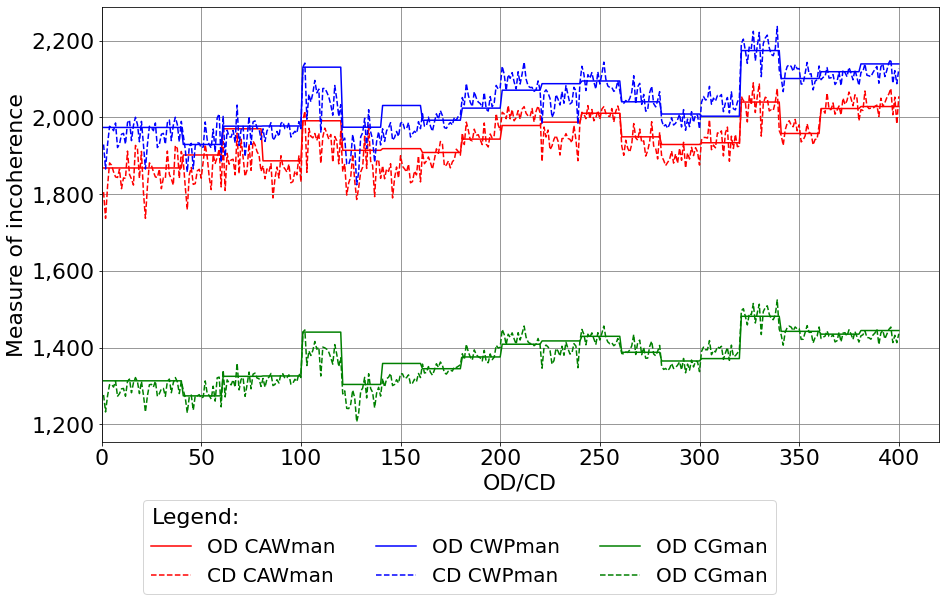

In [290]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [291]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 13912.969964990007
Diferença entre as equação CWP      : 12313.016376490197
Diferença entre as equação CG       : 8046.510777791724


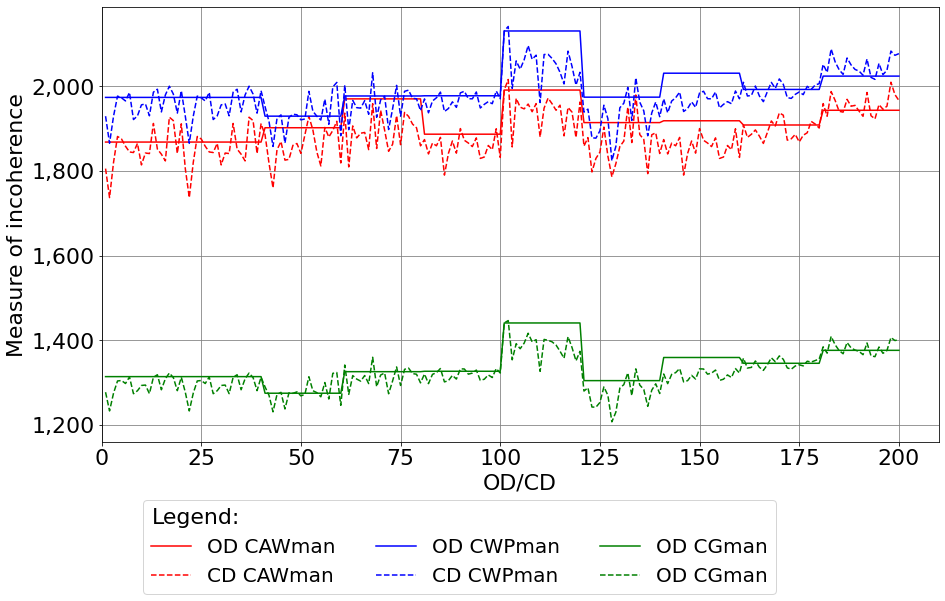

In [292]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

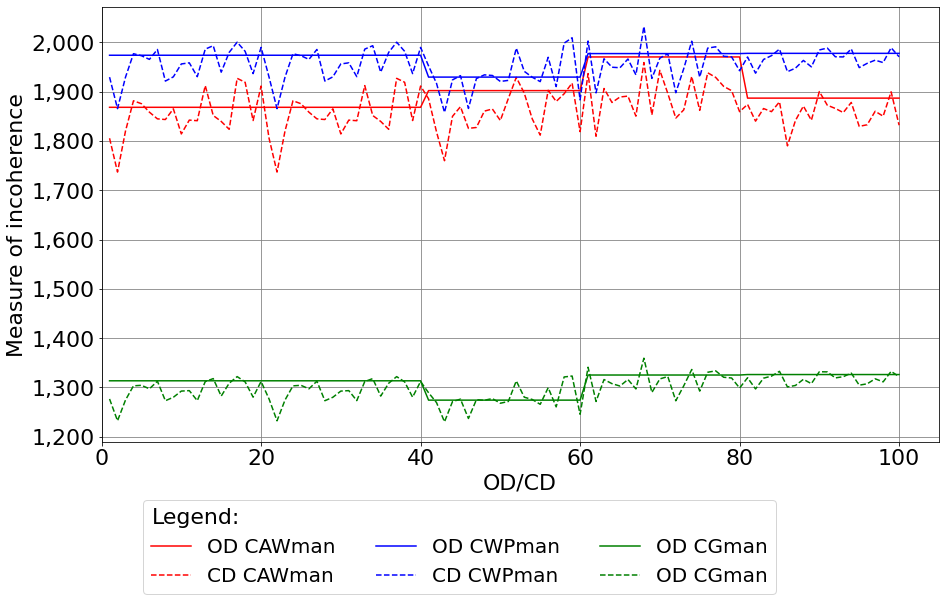

In [293]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

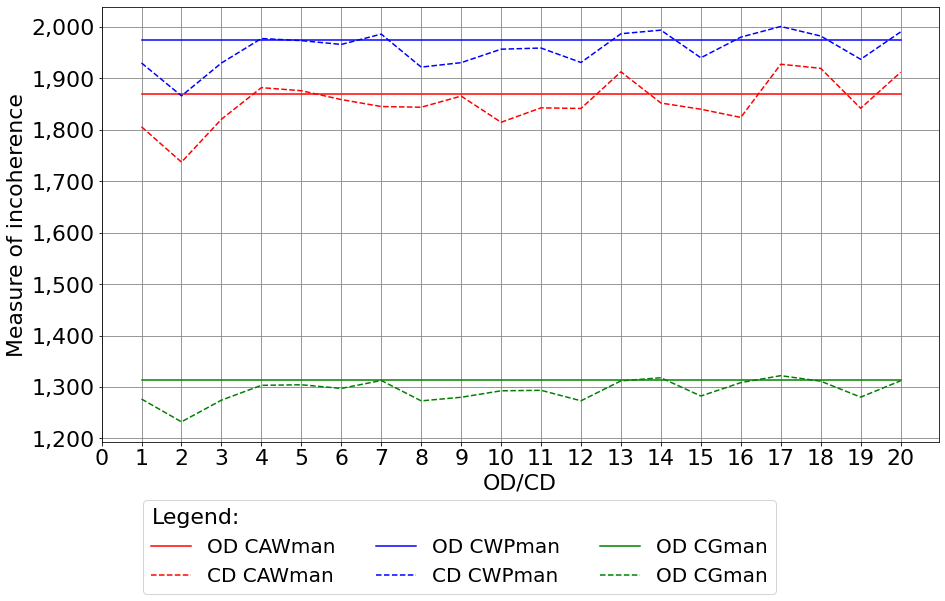

In [294]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

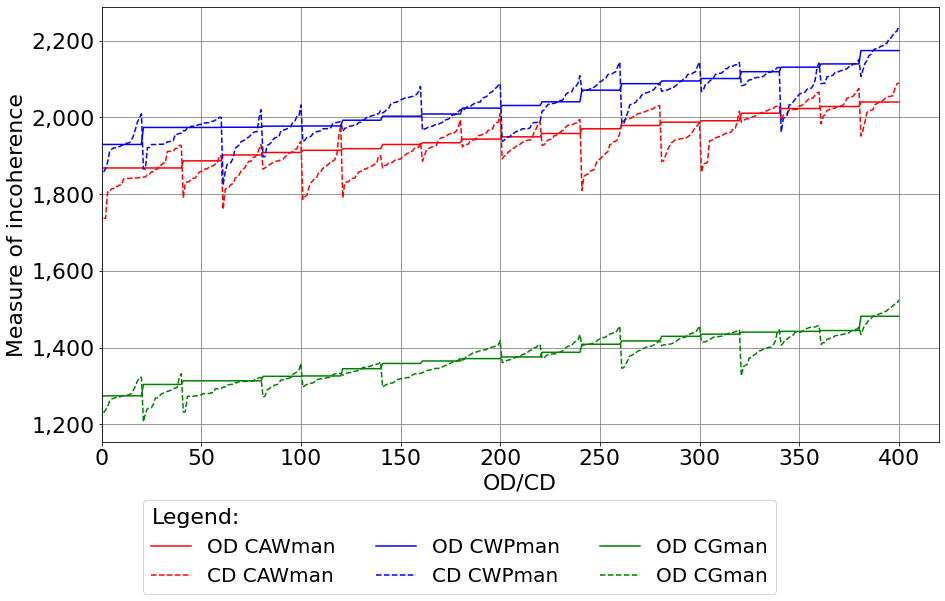

In [295]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

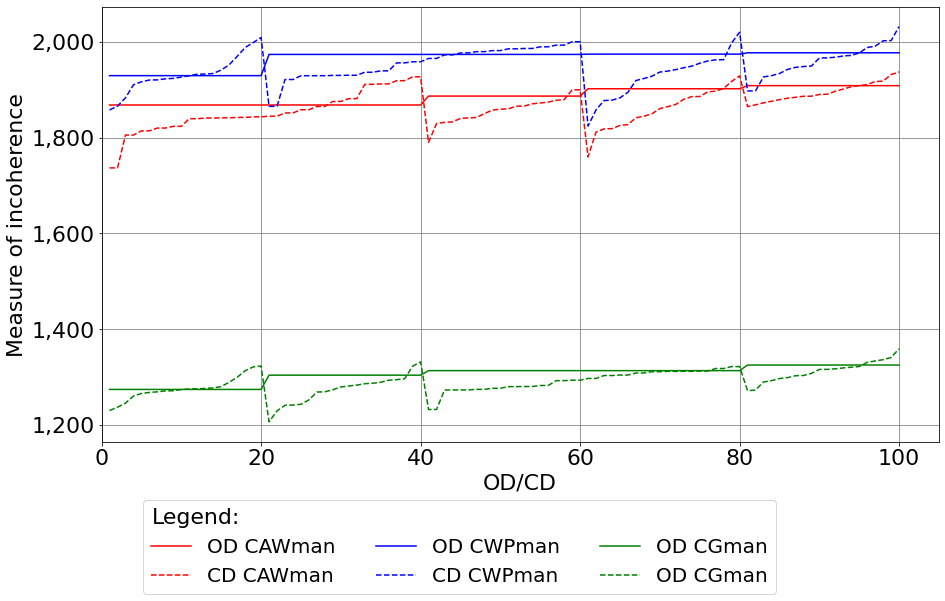

In [296]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

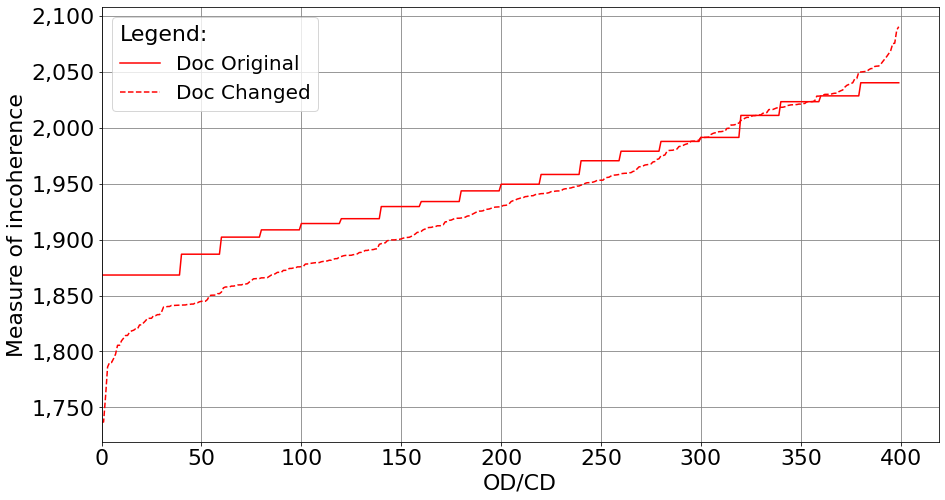

In [297]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

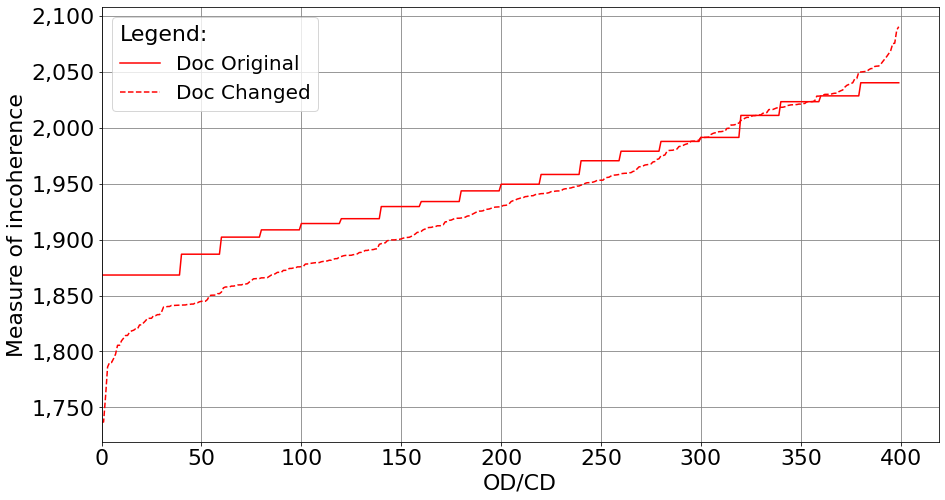

In [298]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

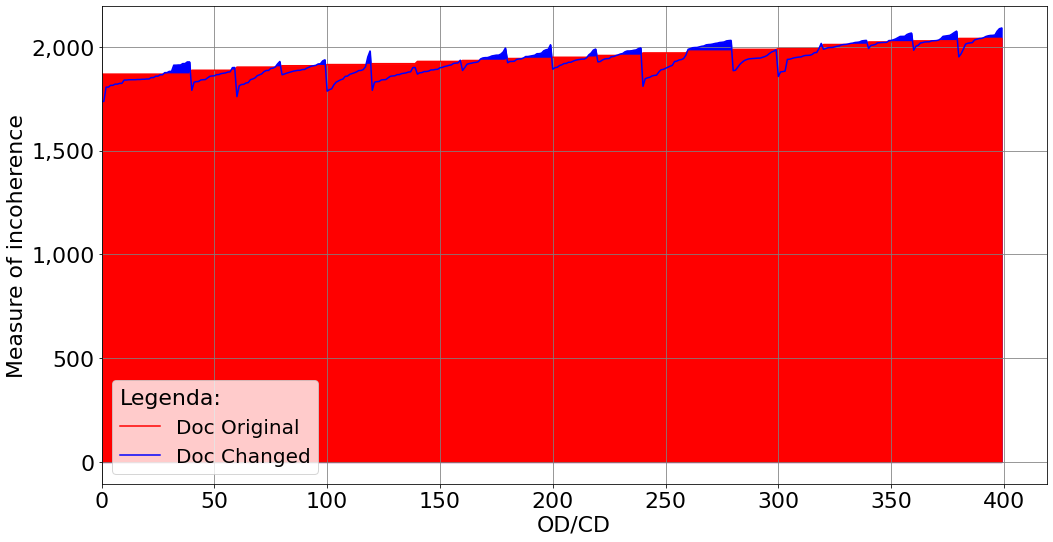

In [299]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [300]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 13912.969964990007

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13p0', 219.64754999999877, 17, 'What is a stack and how to enqueue an element in it?']
['19p0', 349.931027272728, 18, 'In a stack does the enqueue operation occur at which end?']
['20p0', 357.68563636363774, 19, 'In a queue does the push operation occur at which end?']
['18p0', 366.2480615384602, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['10p0', 394.9434400000009, 10, 'What is a stack and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3p0', 941.8842857142854, 4, 'How to push elements in a queue?']
['6p0', 1011.1940727272724, 16, 'How to push and pop elements in a queue data structure?']
['8p0', 1230.5471333333346, 7, 'How t

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [301]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 3082.368606535134

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15p0', 5.651316666666389, 8, 'What is a queue and how to push and pop its elements?']
['6p0', 24.969736363636912, 16, 'How to push and pop elements in a queue data structure?']
['5p0', 26.10956666666675, 3, 'How to push elements in a queue data structure?']
['3p0', 42.81885714285704, 4, 'How to push elements in a queue?']
['9p0', 72.28998000000047, 5, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20p0', 232.2330909090922, 19, 'In a queue does the push operation occur at which end?']
['19p0', 259.39561818181824, 18, 'In a stack doe

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [302]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [303]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 11p0
DO: What is a stack and how to dequeue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to manipulate an element in it ? [dequeue(>CAWman(DO)=1979,0151750000) -> manipulate(CAWman(pertDO)=1988,0038166667)] - VERB/VERB-1-0
  2 - What is a stack and how to define an element in it ? [dequeue(>CAWman(DO)=1979,0151750000) -> define(CAWman(pertDO)=1991,3513250000)] - VERB/VERB-1-0
  3 - What is a stack and how to write an element in it ? [dequeue(>CAWman(DO)=1979,0151750000) -> write(CAWman(pertDO)=1995,4672916667)] - VERB/VERB-1-0
  4 - What is a stack and how to use an element in it ? [dequeue(>CAWman(DO)=1979,0151750000) -> use(CAWman(pertDO)=1996,4889666667)] - VERB/VERB-1-0
  5 - What is a stack and how to find an element in it ? [dequeue(>CAWman(DO)=1979,0151750000) -> find(CAWman(pertDO)=1996,8006250000)] - VERB/VERB-1-0
  6 - What is a stack and how to manage an element in it ? [dequeue(>CAWman(DO)=1979,

In [304]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 11p0
DO: What is a stack and how to dequeue an element in it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
11p0_pert_0;What is a stack and how to put an element in it ?;dequeue;VERB;1979,0151750000;2071,1122205128;1408,8672538462;put;VERB;2013,5638500000;2133,4550576923;1447,4733153846;0,1779942214;0;1
11p0_pert_1;What is a stack and how to place an element in it ?;dequeue;VERB;1979,0151750000;2071,1122205128;1408,8672538462;place;VERB;2009,2977750000;2112,9788743590;1434,5580692308;0,0648714080;0;1
11p0_pert_2;What is a stack and how to find an element in it ?;dequeue;VERB;1979,0151750000;2071,1122205128;1408,8672538462;find;VERB;1996,8006250000;2070,1986576923;1407,4273769231;0,0555005819;0;1
11p0_pert_3;What is a stack and how to store an element in it ?;dequeue;VERB;19

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [305]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 10830.601358454871

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10p0', 70.80836999999951, 10, 'What is a stack and how to enqueue its element?']
['19p0', 90.53540909090975, 18, 'In a stack does the enqueue operation occur at which end?']
['13p0', 116.1167999999991, 17, 'What is a stack and how to enqueue an element in it?']
['20p0', 125.45254545454554, 19, 'In a queue does the push operation occur at which end?']
['18p0', 141.69118461538278, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12p0', 935.558991666667, 15, 'What is a queue and how to pop an eleme

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [306]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [307]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4p0
DO: How to push and pop elements in a queue?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to sing and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> sing(>CAWman(pertDO)=1809,5998666667)] - VERB/VERB-1-0
  2 - How to pop and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> pop(>CAWman(pertDO)=1846,4636333333)] - VERB/NOUN-0-0
  3 - How to go and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> go(>CAWman(pertDO)=1850,3905444444)] - VERB/VERB-1-0
  4 - How to jam and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> jam(>CAWman(pertDO)=1853,1459111111)] - VERB/VERB-1-0
  5 - How to blend and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> blend(>CAWman(pertDO)=1859,4115111111)] - VERB/VERB-1-0
  6 - How to groove and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> groove(>CAWman(pertDO)=1862,1474666667)] - VERB/VERB-1-0
  7 - How to perform and pop elements in a queue 

In [308]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4p0
DO: How to push and pop elements in a queue?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4p0_pert_0;How to rock and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;rock;VERB;1936,7165666667;2002,8056933333;1340,9791400000;0,1207641289;0;1
4p0_pert_1;How to sing and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;sing;VERB;1809,5998666667;1897,6822777778;1271,5317150000;0,0758903325;0;1
4p0_pert_2;How to mix and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;mix;VERB;1906,5176555556;1966,8426222222;1316,0303500000;0,0533997938;0;1
4p0_pert_3;How to dance and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;dance;VERB;1878,1239555556;1949,64

#### Usando CWP

In [309]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 12313.016376490197

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 262.4416618181822, 7, 'What is a queue and how to push its element?']
['19p0', 305.88472878787024, 17, 'In a stack does the enqueue operation occur at which end?']
['5p0', 323.1369933333376, 6, 'How to push elements in a queue data structure?']
['13p0', 375.79141538461727, 15, 'What is a stack and how to enqueue an element in it?']
['14p0', 390.1694448717956, 12, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 818.1051025640998, 8, 'What is a stack and how to enqueue and dequeue its elements?']
['12p0', 835.9778923076849, 14, 'What is a queue and how to pop an element from it?']
['7p0', 1067.4006767857236, 4, 'How to pop elements 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [310]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 3934.818038334448

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 1.8618307692313465, 14, 'What is a queue and how to pop an element from it?']
['6p0', 10.63692121212216, 18, 'How to push and pop elements in a queue data structure?']
['20p0', 14.485621212121714, 19, 'In a queue does the push operation occur at which end?']
['15p0', 17.45668333333083, 9, 'What is a queue and how to push and pop its elements?']
['19p0', 31.15168787879111, 17, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['18p0', 332.1305369230795, 16, 'How are the operations to enqueue and dequeue elements in

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [311]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [312]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to enqueue and link its elements ? [dequeue(>CWPman(DO)=2003,2811205128) -> link(CWPman(pertDO)=2011,7479346154)] - VERB/VERB-1-0
  2 - What is a stack and how to enqueue and manipulate its elements ? [dequeue(>CWPman(DO)=2003,2811205128) -> manipulate(CWPman(pertDO)=2015,1630346154)] - VERB/VERB-1-0
  3 - What is a stack and how to enqueue and stack its elements ? [dequeue(>CWPman(DO)=2003,2811205128) -> stack(CWPman(pertDO)=2019,7370717949)] - VERB/VERB-1-0
  4 - What is a stack and how to enqueue and identify its elements ? [dequeue(>CWPman(DO)=2003,2811205128) -> identify(CWPman(pertDO)=2022,6532102564)] - VERB/VERB-1-0
  5 - What is a stack and how to enqueue and modify its elements ? [dequeue(>CWPman(DO)=2003,2811205128) -> modify(CWPman(pertDO)=2034,5001705128)] - VERB/VERB-1-0
  6 - What is a stack an

In [313]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
16p0_pert_0;What is a stack and how to enqueue and organize its elements ?;dequeue;VERB;1934,0282083333;2003,2811205128;1371,4012261538;organize;VERB;1941,4113166667;2039,1390435897;1389,9739076923;0,0726551339;0;1
16p0_pert_1;What is a stack and how to enqueue and combine its elements ?;dequeue;VERB;1934,0282083333;2003,2811205128;1371,4012261538;combine;VERB;1947,9294333333;2054,6303987179;1401,2684538462;0,0444236547;0;1
16p0_pert_2;What is a stack and how to enqueue and arrange its elements ?;dequeue;VERB;1934,0282083333;2003,2811205128;1371,4012261538;arrange;VERB;1947,8318500000;2045,6324064103;1394,4819307692;0,0423170514;0;1
16p0_pert_3;What is a st

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [314]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 8378.198338155742

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 4.558497435897607, 13, 'What is a stack and how to dequeue an element in it?']
['10p0', 10.749699999998938, 10, 'What is a stack and how to enqueue its element?']
['14p0', 84.27349615384583, 12, 'What is a queue and how to push an element on it?']
['18p0', 101.80950835164595, 16, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['9p0', 149.68771999999694, 7, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4p0', 465.28091111113235, 5, 'How to push and pop elements in a queue?']
['12p0', 834.

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [315]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [316]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to jam and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> jam(>CWPman(pertDO)=1961,7842121212)] - VERB/VERB-1-0
  2 - How to pop and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> pop(>CWPman(pertDO)=1995,3746651515)] - VERB/NOUN-0-0
  3 - How to scratch and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> scratch(>CWPman(pertDO)=2003,0388621212)] - VERB/VERB-1-0
  4 - How to try and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> try(>CWPman(pertDO)=2005,8724181818)] - VERB/VERB-1-0
  5 - How to dump and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> dump(>CWPman(pertDO)=2033,1538606061)] - VERB/VERB-1-0
  6 - How to load and pop elements in a queue data structure ? [push(CWPman(DO)=2131,09

In [317]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;drag;VERB;2016,3287636364;2141,7344348485;1446,1164833333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;pop;NOUN;1856,8926636364;1995,3746651515;1353,2941450000;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

#### Usando CG

In [318]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 8046.510777791724

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 176.88734545454645, 7, 'What is a queue and how to push its element?']
['19p0', 181.11145833333308, 16, 'In a stack does the enqueue operation occur at which end?']
['5p0', 227.89593500000183, 6, 'How to push elements in a queue data structure?']
['18p0', 242.9964042857132, 18, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['10p0', 246.7419727272727, 11, 'What is a stack and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 435.9754499999981, 4, 'How to dequeue elements in a stack?']
['12p0', 567.0777769230779, 14, 'What is a queue and how to pop an element from it?']
['7p0', 701.8245337500048, 2, 'How to pop elements from 

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [319]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 2025.8444491931368

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 0.3405307692307815, 14, 'What is a queue and how to pop an element from it?']
['6p0', 5.696266666667043, 17, 'How to push and pop elements in a queue data structure?']
['15p0', 9.001738461538025, 9, 'What is a queue and how to push and pop its elements?']
['1p0', 12.964987500000007, 3, 'How to dequeue elements in a stack?']
['2p0', 12.964987500000007, 4, 'How to dequeue elements in a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3p0', 188.64725749999957, 1, 'How to push elements in a queue?']
['14p0', 204.28606153846204, 12, 'What is a queue and how to push an

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [320]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [321]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to enqueue and link its elements ? [dequeue(CGman(DO)=1371,4012261538) -> link(>CGman(pertDO)=1366,7445000000)] - VERB/VERB-1-0
  2 - What is a stack and how to enqueue and manipulate its elements ? [dequeue(CGman(DO)=1371,4012261538) -> manipulate(>CGman(pertDO)=1369,3699384615)] - VERB/VERB-1-0
  3 - What is a stack and how to enqueue and identify its elements ? [dequeue(>CGman(DO)=1371,4012261538) -> identify(CGman(pertDO)=1376,9300307692)] - VERB/VERB-1-0
  4 - What is a stack and how to enqueue and stack its elements ? [dequeue(>CGman(DO)=1371,4012261538) -> stack(CGman(pertDO)=1378,9028230769)] - VERB/VERB-1-0
  5 - What is a stack and how to enqueue and modify its elements ? [dequeue(>CGman(DO)=1371,4012261538) -> modify(CGman(pertDO)=1381,5660923077)] - VERB/VERB-1-0
  6 - What is a stack and how to e

In [322]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16p0
DO: What is a stack and how to enqueue and dequeue its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
16p0_pert_0;What is a stack and how to enqueue and organize its elements ?;dequeue;VERB;1934,0282083333;2003,2811205128;1371,4012261538;organize;VERB;1941,4113166667;2039,1390435897;1389,9739076923;0,0726551339;0;1
16p0_pert_1;What is a stack and how to enqueue and combine its elements ?;dequeue;VERB;1934,0282083333;2003,2811205128;1371,4012261538;combine;VERB;1947,9294333333;2054,6303987179;1401,2684538462;0,0444236547;0;1
16p0_pert_2;What is a stack and how to enqueue and arrange its elements ?;dequeue;VERB;1934,0282083333;2003,2811205128;1371,4012261538;arrange;VERB;1947,8318500000;2045,6324064103;1394,4819307692;0,0423170514;0;1
16p0_pert_3;What is a st

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [323]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 6020.6663285985815

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16p0', 6.688013846154263, 10, 'What is a stack and how to enqueue and dequeue its elements?']
['11p0', 7.2584615384619156, 13, 'What is a stack and how to dequeue an element in it?']
['10p0', 63.5825545454577, 11, 'What is a stack and how to enqueue its element?']
['14p0', 63.69726923076814, 12, 'What is a queue and how to push an element on it?']
['9p0', 91.62409999999704, 7, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 423.0104624999981, 4, 'How to dequeue elements in a stack?']
['12p0', 566.7372461538471, 14, 'What is 

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [324]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [325]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to jam and pop elements in a queue data structure ? [push(CGman(DO)=1440,4202166667) -> jam(>CGman(pertDO)=1325,9972083333)] - VERB/VERB-1-0
  2 - How to scratch and pop elements in a queue data structure ? [push(CGman(DO)=1440,4202166667) -> scratch(>CGman(pertDO)=1350,7753000000)] - VERB/VERB-1-0
  3 - How to pop and pop elements in a queue data structure ? [push(CGman(DO)=1440,4202166667) -> pop(>CGman(pertDO)=1353,2941450000)] - VERB/NOUN-0-0
  4 - How to try and pop elements in a queue data structure ? [push(CGman(DO)=1440,4202166667) -> try(>CGman(pertDO)=1356,8804333333)] - VERB/VERB-1-0
  5 - How to load and pop elements in a queue data structure ? [push(CGman(DO)=1440,4202166667) -> load(>CGman(pertDO)=1373,3861750000)] - VERB/VERB-1-0
  6 - How to dump and pop elements in a queue data structure ? [push(CGman(DO)=1440,4202166667) -

In [326]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;drag;VERB;2016,3287636364;2141,7344348485;1446,1164833333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;pop;NOUN;1856,8926636364;1995,3746651515;1353,2941450000;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [327]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 6020.6663285985815

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13p0', 23.01974166666696, 17, 'What is a stack and how to enqueue an element in it?']
['18p0', 36.67056153846147, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['19p0', 42.95432727272714, 18, 'In a stack does the enqueue operation occur at which end?']
['9p0', 43.59434999999962, 5, 'What is a queue and how to push its element?']
['20p0', 47.04449090909111, 19, 'In a queue does the push operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 131.40342857142855, 1, 'How to dequeue elements in a stack?']
['2p0', 131.40342857142855, 2, 'How to dequeue elements in a stack?']
['6p0',

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [328]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 6020.6663285985815

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15p0', 5.651316666666389, 8, 'What is a queue and how to push and pop its elements?']
['5p0', 13.289544444445028, 3, 'How to push elements in a queue data structure?']
['13p0', 19.83528333333379, 17, 'What is a stack and how to enqueue an element in it?']
['6p0', 24.969736363636912, 16, 'How to push and pop elements in a queue data structure?']
['3p0', 26.93908571428551, 4, 'How to push elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 58.76867142857145, 1, 'How to dequeue elements in a stack?']
['2p0', 58.76867142857145, 2, 'How to dequeue elements in a stack?'

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [329]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [330]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 10p0
DO: What is a stack and how to enqueue its element?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB PRON NOUN PUNCT 
  1 - What is a stack and how to organize its element ? [enqueue(CAWman(DO)=1943,5646000000) -> organize(>CAWman(pertDO)=1923,0511800000)] - VERB/VERB-1-0
  2 - What is a stack and how to manipulate its element ? [enqueue(CAWman(DO)=1943,5646000000) -> manipulate(>CAWman(pertDO)=1929,2677600000)] - VERB/VERB-1-0
  3 - What is a stack and how to use its element ? [enqueue(CAWman(DO)=1943,5646000000) -> use(>CAWman(pertDO)=1929,3857700000)] - VERB/VERB-1-0
  4 - What is a stack and how to identify its element ? [enqueue(CAWman(DO)=1943,5646000000) -> identify(>CAWman(pertDO)=1930,6044100000)] - VERB/VERB-1-0
  5 - What is a stack and how to access its element ? [enqueue(CAWman(DO)=1943,5646000000) -> access(>CAWman(pertDO)=1939,1258300000)] - VERB/VERB-1-0
  6 - What is a stack and how to manage its element ? [enqueue(CAWman(DO)=1943,5646000000) -> manage(>CAWman(

In [331]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 10p0
DO: What is a stack and how to enqueue its element?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
10p0_pert_0;What is a stack and how to define its element ?;enqueue;VERB;1943,5646000000;2024,3401345455;1375,6998181818;define;VERB;1959,2984600000;2051,9748745455;1384,0049636364;0,1030245051;0;1
10p0_pert_1;What is a stack and how to use its element ?;enqueue;VERB;1943,5646000000;2024,3401345455;1375,6998181818;use;VERB;1929,3857700000;2033,0777818182;1368,9846454545;0,1002862304;0;1
10p0_pert_2;What is a stack and how to find its element ?;enqueue;VERB;1943,5646000000;2024,3401345455;1375,6998181818;find;VERB;1987,8589700000;2088,5605036364;1408,6907727273;0,0541970320;0;1
10p0_pert_3;What is a stack and how to describe its element ?;enqueue;VERB;1943,5646000000;2024,340134545

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [332]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 6020.6663285985815

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10p0', 20.513419999999996, 10, 'What is a stack and how to enqueue its element?']
['13p0', 23.01974166666696, 17, 'What is a stack and how to enqueue an element in it?']
['18p0', 30.890761538460993, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['19p0', 31.832772727272868, 18, 'In a stack does the enqueue operation occur at which end?']
['9p0', 43.59434999999962, 5, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 131.40342857142855, 1, 'How to dequeue elements in a stack?']
['2p0', 131.4034285714

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [333]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [334]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4p0
DO: How to push and pop elements in a queue?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to sing and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> sing(>CAWman(pertDO)=1809,5998666667)] - VERB/VERB-1-0
  2 - How to pop and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> pop(>CAWman(pertDO)=1846,4636333333)] - VERB/NOUN-0-0
  3 - How to go and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> go(>CAWman(pertDO)=1850,3905444444)] - VERB/VERB-1-0
  4 - How to jam and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> jam(>CAWman(pertDO)=1853,1459111111)] - VERB/VERB-1-0
  5 - How to blend and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> blend(>CAWman(pertDO)=1859,4115111111)] - VERB/VERB-1-0
  6 - How to groove and pop elements in a queue ? [push(CAWman(DO)=1970,4900333333) -> groove(>CAWman(pertDO)=1862,1474666667)] - VERB/VERB-1-0
  7 - How to perform and pop elements in a queue 

In [335]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4p0
DO: How to push and pop elements in a queue?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4p0_pert_0;How to rock and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;rock;VERB;1936,7165666667;2002,8056933333;1340,9791400000;0,1207641289;0;1
4p0_pert_1;How to sing and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;sing;VERB;1809,5998666667;1897,6822777778;1271,5317150000;0,0758903325;0;1
4p0_pert_2;How to mix and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;mix;VERB;1906,5176555556;1966,8426222222;1316,0303500000;0,0533997938;0;1
4p0_pert_3;How to dance and pop elements in a queue ?;push;VERB;1970,4900333333;1977,3328822222;1325,2072160000;dance;VERB;1878,1239555556;1949,64

#### Usando CWP






In [336]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 6020.6663285985815

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 28.959501818181025, 7, 'What is a queue and how to push its element?']
['19p0', 36.420695454545694, 17, 'In a stack does the enqueue operation occur at which end?']
['5p0', 40.26061555555589, 6, 'How to push elements in a queue data structure?']
['18p0', 41.970269670330254, 16, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['15p0', 42.50069743589802, 9, 'What is a queue and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12p0', 105.01493461538416, 14, 'What is a queue and how to pop an element from it?']
['1p0', 108.36743214285684, 2, 'How to dequeue elements in a stack

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [337]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 6020.6663285985815

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 1.8618307692313465, 14, 'What is a queue and how to pop an element from it?']
['6p0', 10.63692121212216, 18, 'How to push and pop elements in a queue data structure?']
['19p0', 11.254869696969763, 17, 'In a stack does the enqueue operation occur at which end?']
['5p0', 11.31530666666572, 6, 'How to push elements in a queue data structure?']
['15p0', 11.45754487179397, 9, 'What is a queue and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10p0', 64.22036909090957, 10, 'What is a stack and how to enqueue its element?']
['14p0', 68.02085897435927, 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [338]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [339]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> organize(>CAWman(pertDO)=1760,0129571429)] - VERB/VERB-1-0
  2 - How to use elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> use(>CAWman(pertDO)=1811,8605000000)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> arrange(>CAWman(pertDO)=1818,3713714286)] - VERB/VERB-1-0
  4 - How to process elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> process(>CAWman(pertDO)=1818,9520857143)] - VERB/VERB-1-0
  5 - How to sort elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> sort(>CAWman(pertDO)=1825,5744000000)] - VERB/VERB-1-0
  6 - How to store elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> store(>CAWman(pertDO)=1827,4577714286)] - VERB/VERB-1-0
  7 - How to identify elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> identify(>CAW

In [340]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;place;VERB;1885,8678285714;1952,3216107143;1289,2531062500;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;arrange;VERB;1818,3713714286;1916,8501785714;1269,2526562500;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;organize;VERB;1760,0129571429;1857,9980892857;1230,2460375000;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;manage;VERB;1849,9696571429;1923,9581107143;1271,2374875000;0,0467

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [341]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 6020.6663285985815

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 3.054708974359073, 13, 'What is a stack and how to dequeue an element in it?']
['10p0', 7.697685454544853, 10, 'What is a stack and how to enqueue its element?']
['14p0', 24.580729487178587, 12, 'What is a queue and how to push an element on it?']
['13p0', 27.04676410256434, 15, 'What is a stack and how to enqueue an element in it?']
['9p0', 28.959501818181025, 7, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12p0', 105.01493461538416, 14, 'What is a queue and how to pop an element from it?']
['1p0', 108.36743214285684, 2, 'How to d

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [342]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [343]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to pop and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> pop(>CAWman(pertDO)=1856,8926636364)] - VERB/NOUN-0-0
  2 - How to scratch and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> scratch(>CAWman(pertDO)=1879,0913000000)] - VERB/VERB-1-0
  3 - How to jam and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> jam(>CAWman(pertDO)=1880,5382545455)] - VERB/VERB-1-0
  4 - How to try and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> try(>CAWman(pertDO)=1883,0113272727)] - VERB/VERB-1-0
  5 - How to sit and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> sit(>CAWman(pertDO)=1939,2357000000)] - VERB/VERB-1-0
  6 - How to squeeze and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3

In [344]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;drag;VERB;2016,3287636364;2141,7344348485;1446,1164833333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;pop;NOUN;1856,8926636364;1995,3746651515;1353,2941450000;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

#### Usando CG






In [345]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 6020.6663285985815

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 17.42257272727329, 7, 'What is a queue and how to push its element?']
['19p0', 20.690545833333317, 16, 'In a stack does the enqueue operation occur at which end?']
['13p0', 26.7916923076923, 15, 'What is a stack and how to enqueue an element in it?']
['5p0', 29.256680000000188, 6, 'How to push elements in a queue data structure?']
['15p0', 30.761246153846514, 9, 'What is a queue and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12p0', 71.14547692307724, 14, 'What is a queue and how to pop an element from it?']
['1p0', 81.15623749999986, 3, 'How to dequeue elements in a stack?']
['2p0', 81.15623749999986, 

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [346]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 6020.6663285985815

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 0.3405307692307815, 14, 'What is a queue and how to pop an element from it?']
['6p0', 5.696266666667043, 17, 'How to push and pop elements in a queue data structure?']
['5p0', 6.5023100000000795, 6, 'How to push elements in a queue data structure?']
['15p0', 6.611592307692263, 9, 'What is a queue and how to push and pop its elements?']
['1p0', 8.494275000000016, 3, 'How to dequeue elements in a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17p0', 42.67238571428538, 20, 'How are the operations to push and pop elements in a queue implemented?']
['14p0', 46.400353846154076, 1

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [347]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [348]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> organize(>CAWman(pertDO)=1760,0129571429)] - VERB/VERB-1-0
  2 - How to use elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> use(>CAWman(pertDO)=1811,8605000000)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> arrange(>CAWman(pertDO)=1818,3713714286)] - VERB/VERB-1-0
  4 - How to process elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> process(>CAWman(pertDO)=1818,9520857143)] - VERB/VERB-1-0
  5 - How to sort elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> sort(>CAWman(pertDO)=1825,5744000000)] - VERB/VERB-1-0
  6 - How to store elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> store(>CAWman(pertDO)=1827,4577714286)] - VERB/VERB-1-0
  7 - How to identify elements in a queue ? [push(CAWman(DO)=1902,2241428571) -> identify(>CAW

In [349]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;place;VERB;1885,8678285714;1952,3216107143;1289,2531062500;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;arrange;VERB;1818,3713714286;1916,8501785714;1269,2526562500;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;organize;VERB;1760,0129571429;1857,9980892857;1230,2460375000;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;1902,2241428571;1929,6217785714;1274,2460087500;manage;VERB;1849,9696571429;1923,9581107143;1271,2374875000;0,0467

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [350]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 6020.6663285985815

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 3.8931076923079218, 13, 'What is a stack and how to dequeue an element in it?']
['16p0', 4.656726153846421, 10, 'What is a stack and how to enqueue and dequeue its elements?']
['10p0', 15.01837272727289, 11, 'What is a stack and how to enqueue its element?']
['14p0', 15.498053846153653, 12, 'What is a queue and how to push an element on it?']
['9p0', 16.808018181817715, 7, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12p0', 71.14547692307724, 14, 'What is a queue and how to pop an element from it?']
['1p0', 81.15623749999986, 3, 'How

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [351]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [352]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to pop and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> pop(>CAWman(pertDO)=1856,8926636364)] - VERB/NOUN-0-0
  2 - How to scratch and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> scratch(>CAWman(pertDO)=1879,0913000000)] - VERB/VERB-1-0
  3 - How to jam and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> jam(>CAWman(pertDO)=1880,5382545455)] - VERB/VERB-1-0
  4 - How to try and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> try(>CAWman(pertDO)=1883,0113272727)] - VERB/VERB-1-0
  5 - How to sit and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> sit(>CAWman(pertDO)=1939,2357000000)] - VERB/VERB-1-0
  6 - How to squeeze and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3

In [353]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;drag;VERB;2016,3287636364;2141,7344348485;1446,1164833333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4202166667;pop;NOUN;1856,8926636364;1995,3746651515;1353,2941450000;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

# 4 Finalização

## 4.1 Tempo final de processamento



In [354]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:01:22 (h:mm:ss)
